In [2]:
EPOCHS = 500
LR = 3e-3
LABEL_SMOOTHING = 0.
WEIGHT_DECAY = 0#5e-4
WARMUP_EPOCHS = 0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from typing import List, Tuple, Optional
from torch.optim import Adam, AdamW, Adamax, SGD
import torch.optim as optim

device='cuda' if torch.cuda.is_available() else 'cpu'
import torch
def similarity_matrix(x):
    ''' Calculate adjusted cosine similarity matrix of size x.size(0) x x.size(0). '''
    if x.dim() == 4:
        x = x.view(x.size(0),-1)
    xc = x - x.mean(dim=1).unsqueeze(1)
    xn = xc / (1e-8 + torch.sqrt(torch.sum(xc**2, dim=1))).unsqueeze(1)
    R = xn.matmul(xn.transpose(1,0)).clamp(-1,1)
    return R

def L_per(q: torch.Tensor, p: torch.Tensor,
                      reduction: str = "mean",
                      eps: float = 1e-12,
                      detach_p: bool = True) -> torch.Tensor:
    """
    q, p: [B, K] probabilities (nonnegative; rows ~ sum to 1).
    """
    if detach_p:
        p = p.detach()
    q = (q.clamp_min(eps) / q.clamp_min(eps).sum(dim=-1, keepdim=True))
    p = (p.clamp_min(eps) / p.clamp_min(eps).sum(dim=-1, keepdim=True))
    # log BC via log-sum-exp for stability
    log_bc = torch.logsumexp(0.5 * (q.log() + p.log()), dim=-1)
    loss_per = -log_bc
    return (loss_per.mean() if reduction == "mean"
            else loss_per.sum() if reduction == "sum"
            else loss_per)
    
class VGG11(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        num_classes: int = 200,
        lr: float = 0.001,
    ):
        super().__init__()
        
        self.num_classes = num_classes
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = 1
        

        self.conv_configs = [
            (in_channels, 256),    # Conv1 - pool
            (256, 512),           # Conv2 - pool
            (512, 512),          # Conv3
            (512, 1024),          # Conv4 - pool
            (1024, 1024),          # Conv5
            (1024, 1024),          # Conv6 - pool
            (1024, 1024),          # Conv7
            (1024, 1024),          # Conv8 - pool
        ]
        
        self.conv_layers = nn.ModuleList()
        self.conv_norms = nn.ModuleList() 
        self.conv_beta = nn.ParameterList() 
        
        self.conv_optimizers = []
        self.conv_param_layer = []
        
        for i, (in_ch, out_ch) in enumerate(self.conv_configs):
            conv_i = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            bn_i = nn.BatchNorm2d(out_ch)
            self.conv_layers.append(conv_i)
            self.conv_norms.append(bn_i)
                
            selected_params = list(conv_i.parameters())
            selected_params += list(bn_i.parameters())
            self.conv_optimizers.append(Adam(selected_params,lr = LR,eps=1e-8, betas=(.9, .999),weight_decay=WEIGHT_DECAY))
            self.conv_param_layer.append(selected_params)
            
        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.conv_optimizers[0], T_max=EPOCHS, eta_min=1e-5)
        self.feature_size = 1024
        
        self.fc_configs = [
            (self.feature_size, 4096),
            (4096,4096),
            (4096, num_classes)
        ]
        
        self.fc_layers = nn.ModuleList()
        self.fc_norms = nn.ModuleList()
        self.fc_optimizers = []
        self.fc_param_layer = []
        
        for i, (in_features, out_features) in enumerate(self.fc_configs):
            layer_i = nn.Linear(in_features, out_features)
            self.fc_layers.append(layer_i)
            if i < len(self.fc_configs) - 1:
                bn_i = nn.BatchNorm1d(out_features)
                self.fc_norms.append(bn_i)
            else:
                bn_i = nn.LayerNorm(out_features)
                self.fc_norms.append(bn_i)
            selected_params = list(layer_i.parameters())
            selected_params += list(bn_i.parameters())
            self.fc_optimizers.append(Adam(selected_params,lr = lr,eps=1e-8, betas=(.9, .999),weight_decay=WEIGHT_DECAY))
            self.fc_param_layer.append(selected_params)
            
        self.optimizers = self.fc_optimizers + self.conv_optimizers
        self._init_weights()
        
        self.out_features = 1024
        self.conv_projections = []
        input_size = 64
        for i, layer in enumerate(self.conv_layers):
            out_channels = layer.out_channels
            if i in [0, 1, 3, 5, 7]:  # Layers with pooling
                input_size = input_size // 2
            if input_size >8:
                feat_size = out_channels * 64
            else:
                feat_size = out_channels * input_size * input_size
            proj_dim = self.compute_dim_proj(feat_size)+self.num_classes
            R = torch.randn(proj_dim, self.num_classes).to(self.device) / np.sqrt(proj_dim)
            self.conv_projections.append(R)
        
        self.fc_projections = []
        for layer in self.fc_layers[:-1]:
            R = torch.randn(layer.out_features+self.num_classes, self.num_classes).to(self.device) / np.sqrt(layer.out_features)
            self.fc_projections.append(R)
        
        
        
    def compute_conv_drift(self, features, targets, pre_feat,layer_idx: int):
        """Compute supervised drift for initial conv layer"""
        tg_onehote = F.one_hot(targets, num_classes=self.num_classes).float()
        batch_size, channels, height, width = features.shape
        if height > 8:
            avg_feat = F.adaptive_avg_pool2d(features, (8, 8))
        else:
            avg_feat = features
        flattened = avg_feat.view(batch_size, -1)
        flattened = F.adaptive_avg_pool1d(flattened, self.conv_projections[layer_idx].shape[0])
        logits = flattened @ F.dropout(self.conv_projections[layer_idx], p=0.1)
        ce_loss  = F.cross_entropy(logits, targets,label_smoothing=LABEL_SMOOTHING)
        if pre_feat is not None:
            sim_loss = L_per(F.softmax(logits,dim=-1),pre_feat.detach())
        else:
            sim_loss = L_per(F.softmax(logits,dim=-1),tg_onehote)
            
        loss = 0.5*ce_loss + 0.5* sim_loss
        grad = torch.autograd.grad(loss, features, retain_graph=True)[0]
        return grad, F.softmax(logits, dim=1)

        
    def compute_fc_drift(self, activations: torch.Tensor, targets: torch.Tensor, pre_feat: torch.Tensor,
                                 layer_idx: int) -> torch.Tensor:
        tg_onehote = F.one_hot(targets, num_classes=self.num_classes).float()
        sup_act = torch.cat((activations, tg_onehote), dim=1)
        layer_output = torch.matmul(sup_act, F.dropout(self.fc_projections[layer_idx],.1))
        # add the feature aligment loss
        if pre_feat is not None:
            ce_loss = F.cross_entropy(layer_output, targets, label_smoothing=LABEL_SMOOTHING) 
            sim_loss = L_per(F.softmax(layer_output,dim=-1),pre_feat.detach())
        else:
            ce_loss = F.cross_entropy(layer_output, targets)
            sim_loss = F.mse_loss(similarity_matrix(layer_output), similarity_matrix(tg_onehote))
        
        loss = 0.2*ce_loss + 0.8* sim_loss
        grad = torch.autograd.grad(loss, activations, retain_graph=False)[0]
        return grad, F.softmax(layer_output, dim=1)
    
    def forward_with_update(self, x: torch.Tensor,y: torch.Tensor):
        # zero_grad all optimizers
        self.opts_zero_grad()
        pre_Rproj = None
        
        h = x
        
        for i, (conv, norm) in enumerate(zip(self.conv_layers, self.conv_norms)):
            h = h.detach()
            h = conv(h)
            h = norm(h)
            h = F.relu(h)
            if i in [0, 1, 3, 5, 7]:
                h = F.max_pool2d(h, 2)
            # update the layer
            supervised_drift,pre_Rproj = self.compute_conv_drift(h,y,pre_Rproj,i)
            h.backward(supervised_drift)
            # torch.nn.utils.clip_grad_norm_(self.conv_param_layer[i], max_norm=1.0)
            self.conv_optimizers[i].step()
        
        h = F.adaptive_avg_pool2d(h, (1, 1))

        h = h.view(h.size(0), -1)
        
        
        for i, fc in enumerate(self.fc_layers[:-1]):
            h = h.detach()
            h = fc(h)
            if i < len(self.fc_norms):
                h = self.fc_norms[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=0.5, training=self.training)
            # update the layer
            supervised_drift,pre_Rproj = self.compute_fc_drift(
                h,y,pre_Rproj,i)
            h.backward(supervised_drift)
            # torch.nn.utils.clip_grad_norm_(self.fc_param_layer[i], max_norm=1.0)
            self.fc_optimizers[i].step()

        h = h.detach()
        h = self.fc_norms[-1](self.fc_layers[-1](h))
        # h = self.fc_layers[-1](h)
        loss = F.cross_entropy(h, y) + L_per(F.softmax(h,dim=-1),pre_Rproj.detach())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.fc_param_layer[-1], max_norm=1.0)
        self.fc_optimizers[-1].step()
        
        return h, loss.item()
    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = x
        
        for i, (conv, norm) in enumerate(zip(self.conv_layers, self.conv_norms)):
            h = conv(h)
            h = norm(h)
            h = F.relu(h)
            if i in [0, 1, 3, 5, 7]:
                h = F.max_pool2d(h, 2)
                
        h = F.adaptive_avg_pool2d(h, (1, 1))
        h = h.view(h.size(0), -1)
        
        for i, fc in enumerate(self.fc_layers[:-1]):
            h = fc(h)
            if i < len(self.fc_norms):
                h = self.fc_norms[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=0.1, training=self.training)
        
        return self.fc_norms[-1](self.fc_layers[-1](h))
        # return self.fc_layers[-1](h)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                
    def opts_zero_grad(self):
        for opt_l in self.conv_optimizers+self.fc_optimizers:
            opt_l.zero_grad()
    def id_zero_grad(self,i):
        self.optimizers[i].zero_grad()
    def compute_dim_proj(self, in_dim: int) -> int:
        eps = 0.1
        min_dim = int(4 * np.log(in_dim) / (eps**2/2 - eps**3/3))
        return min(in_dim, max(min_dim, 2048))
    
    def update_lr(self):
        lr = self.scheduler.get_last_lr()[0]  # Get the updated LR from the scheduler
        for opt_i in self.optimizers:
            for param_group in opt_i.param_groups:
                param_group['lr'] = lr
                
                

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from PIL import Image
import torch

class RAMImageFolder(Dataset): # faster
    def __init__(self, root, transform=None):
        base = datasets.ImageFolder(root)
        self.classes  = base.classes
        self.class_to_idx = base.class_to_idx
        self.samples  = base.samples           # (path, label)
        self.transform = transform

        # --- preload all images into RAM as PIL (copy() closes file & keeps pixels in memory)
        imgs, labels = [], []
        for path, y in self.samples:
            with Image.open(path) as im:
                imgs.append(im.convert("RGB").copy())
            labels.append(y)
        self.imgs = imgs
        self.targets = torch.as_tensor(labels)

    def __len__(self): return len(self.imgs)

    def __getitem__(self, i):
        img = self.imgs[i]
        if self.transform is not None:
            img = self.transform(img)  # your existing PIL-based transforms work
        return img, int(self.targets[i])


In [ ]:
def train_cifar10(
    n_epochs=100,
    batch_size=64,
    learning_rate=0.001,
    save_model=True
):  
    from ADL.aug_cifar10_policy import CIFAR10Policy
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    train_transform = transforms.Compose([
        transforms.RandomCrop(64, padding=4),
        transforms.RandomHorizontalFlip(),
        CIFAR10Policy(),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
        # transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2770, 0.2691, 0.2821]), 
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
        # transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2770, 0.2691, 0.2821]),
    ])


    data_dir = "/scratch-shared/20220510/img200/tiny-imagenet-200/"
    # train_dataset = datasets.ImageFolder(data_dir+"train", transform = train_transform)
    # test_dataset = datasets.ImageFolder(data_dir+"val", transform = test_transform)
    train_dataset = RAMImageFolder(data_dir+"train", transform=train_transform)
    test_dataset  = RAMImageFolder(data_dir+"val",   transform=test_transform)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print('data loaded')
    # Initialize model and optimizer
    model = VGG11(lr=learning_rate).to(device)

    # Training history
    history = defaultdict(list)
    best_accuracy = 0.66

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        n_batches = 0
        correct = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output,loss = model.forward_with_update(data, target)

            epoch_loss += loss
            n_batches += 1
            
            pred = output.argmax(dim=1, keepdim=True)
            right_ = pred.eq(target.view_as(pred)).sum().item()
            correct += right_
            accuracy = correct / len(train_loader.dataset)

            pbar.set_postfix({'loss': f'{loss:.4f}',
                              'acc_t': f'{right_/len(pred):.4f}', 'acc': f'{accuracy:.4f}'})
        if model.scheduler is not None:
            model.scheduler.step()
            model.update_lr()
        # if epoch % 100 ==0  and epoch>1:
        #     model.alpha = model.alpha*.75

        # Evaluate
        avg_train_loss = epoch_loss / n_batches
        test_loss, test_accuracy = evaluate_model(model, test_loader, device)


        # Store history
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        # # Save best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            # if save_model:
            #     torch.save(model.state_dict(), 'c100_vgg11x2bz-'+str(best_accuracy)+'.pth')
        if epoch % 1 == 0:
            # print(f'Epoch {epoch+1}/{n_epochs}:')
            print(f'Average Train Loss: {avg_train_loss:.4f}; Test Loss: {test_loss:.4f}; \
                Train Accuracy: {accuracy:.4f}; Test Accuracy: {test_accuracy:.4f};')

    return model, history

def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

# if __name__ == "__main__":
# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Train the model
model, history = train_cifar10(
    n_epochs=EPOCHS,
    batch_size=512,
    learning_rate=LR,
)

Using device: cuda
data loaded


Epoch 1/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:10<00:00,  2.77it/s, loss=5.1247, acc_t=0.0187, acc=0.0113]


Average Train Loss: 5.4135; Test Loss: 4.9289;                 Train Accuracy: 0.0113; Test Accuracy: 0.0264;


Epoch 2/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=4.7575, acc_t=0.0625, acc=0.0397]


Average Train Loss: 4.8944; Test Loss: 4.4871;                 Train Accuracy: 0.0397; Test Accuracy: 0.0796;


Epoch 3/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=4.4103, acc_t=0.1125, acc=0.0668]


Average Train Loss: 4.6302; Test Loss: 4.2893;                 Train Accuracy: 0.0668; Test Accuracy: 0.0912;


Epoch 4/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=4.5869, acc_t=0.0563, acc=0.0858]


Average Train Loss: 4.4673; Test Loss: 4.1098;                 Train Accuracy: 0.0858; Test Accuracy: 0.1220;


Epoch 5/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=4.1048, acc_t=0.1375, acc=0.1058]


Average Train Loss: 4.3308; Test Loss: 3.9321;                 Train Accuracy: 0.1058; Test Accuracy: 0.1486;


Epoch 6/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=4.2794, acc_t=0.1125, acc=0.1164]


Average Train Loss: 4.2496; Test Loss: 3.9286;                 Train Accuracy: 0.1164; Test Accuracy: 0.1490;


Epoch 7/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=4.0986, acc_t=0.1250, acc=0.1294]


Average Train Loss: 4.1563; Test Loss: 3.9944;                 Train Accuracy: 0.1294; Test Accuracy: 0.1456;


Epoch 8/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.8780, acc_t=0.1688, acc=0.1425]


Average Train Loss: 4.0707; Test Loss: 3.7391;                 Train Accuracy: 0.1425; Test Accuracy: 0.1846;


Epoch 9/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=4.1062, acc_t=0.1313, acc=0.1546]


Average Train Loss: 4.0017; Test Loss: 3.6225;                 Train Accuracy: 0.1546; Test Accuracy: 0.1912;


Epoch 10/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=4.0153, acc_t=0.1437, acc=0.1602]


Average Train Loss: 3.9615; Test Loss: 3.6374;                 Train Accuracy: 0.1602; Test Accuracy: 0.1924;


Epoch 11/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.8238, acc_t=0.1688, acc=0.1698]


Average Train Loss: 3.9051; Test Loss: 3.5489;                 Train Accuracy: 0.1698; Test Accuracy: 0.2104;


Epoch 12/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=4.1246, acc_t=0.1375, acc=0.1781]


Average Train Loss: 3.8411; Test Loss: 3.5644;                 Train Accuracy: 0.1781; Test Accuracy: 0.2068;


Epoch 13/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.7645, acc_t=0.1812, acc=0.1882]


Average Train Loss: 3.7941; Test Loss: 3.4748;                 Train Accuracy: 0.1882; Test Accuracy: 0.2126;


Epoch 14/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.7552, acc_t=0.2125, acc=0.1912]


Average Train Loss: 3.7648; Test Loss: 3.3810;                 Train Accuracy: 0.1912; Test Accuracy: 0.2358;


Epoch 15/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=3.9587, acc_t=0.1875, acc=0.2020]


Average Train Loss: 3.7079; Test Loss: 3.3371;                 Train Accuracy: 0.2020; Test Accuracy: 0.2430;


Epoch 16/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=3.6533, acc_t=0.2125, acc=0.2068]


Average Train Loss: 3.6713; Test Loss: 3.3668;                 Train Accuracy: 0.2068; Test Accuracy: 0.2366;


Epoch 17/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.8372, acc_t=0.1750, acc=0.2126]


Average Train Loss: 3.6420; Test Loss: 3.2891;                 Train Accuracy: 0.2126; Test Accuracy: 0.2524;


Epoch 18/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.9662, acc_t=0.1875, acc=0.2210]


Average Train Loss: 3.5880; Test Loss: 3.2768;                 Train Accuracy: 0.2210; Test Accuracy: 0.2500;


Epoch 19/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=3.2945, acc_t=0.2812, acc=0.2292]


Average Train Loss: 3.5407; Test Loss: 3.1350;                 Train Accuracy: 0.2292; Test Accuracy: 0.2768;


Epoch 20/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=3.4742, acc_t=0.2750, acc=0.2322]


Average Train Loss: 3.5239; Test Loss: 3.1669;                 Train Accuracy: 0.2322; Test Accuracy: 0.2704;


Epoch 21/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.3992, acc_t=0.2375, acc=0.2366]


Average Train Loss: 3.4936; Test Loss: 3.1391;                 Train Accuracy: 0.2366; Test Accuracy: 0.2770;


Epoch 22/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=3.3412, acc_t=0.2562, acc=0.2441]


Average Train Loss: 3.4498; Test Loss: 3.1798;                 Train Accuracy: 0.2441; Test Accuracy: 0.2670;


Epoch 23/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=3.2852, acc_t=0.2812, acc=0.2490]


Average Train Loss: 3.4270; Test Loss: 3.1055;                 Train Accuracy: 0.2490; Test Accuracy: 0.2858;


Epoch 24/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.7193, acc_t=0.1812, acc=0.2529]


Average Train Loss: 3.4158; Test Loss: 3.1493;                 Train Accuracy: 0.2529; Test Accuracy: 0.2718;


Epoch 25/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=3.1606, acc_t=0.3063, acc=0.2602]


Average Train Loss: 3.3759; Test Loss: 3.1280;                 Train Accuracy: 0.2602; Test Accuracy: 0.2868;


Epoch 26/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.2818, acc_t=0.2313, acc=0.2650]


Average Train Loss: 3.3377; Test Loss: 3.0272;                 Train Accuracy: 0.2650; Test Accuracy: 0.3022;


Epoch 27/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=3.5613, acc_t=0.2437, acc=0.2671]


Average Train Loss: 3.3289; Test Loss: 3.0347;                 Train Accuracy: 0.2671; Test Accuracy: 0.2962;


Epoch 28/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=3.4098, acc_t=0.2750, acc=0.2731]


Average Train Loss: 3.2977; Test Loss: 3.1674;                 Train Accuracy: 0.2731; Test Accuracy: 0.2838;


Epoch 29/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.3334, acc_t=0.2750, acc=0.2799]


Average Train Loss: 3.2602; Test Loss: 2.9573;                 Train Accuracy: 0.2799; Test Accuracy: 0.3186;


Epoch 30/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.2184, acc_t=0.3187, acc=0.2825]


Average Train Loss: 3.2341; Test Loss: 2.9378;                 Train Accuracy: 0.2825; Test Accuracy: 0.3220;


Epoch 31/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.3313, acc_t=0.2375, acc=0.2835]


Average Train Loss: 3.2321; Test Loss: 3.0221;                 Train Accuracy: 0.2835; Test Accuracy: 0.2990;


Epoch 32/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.83it/s, loss=3.0845, acc_t=0.3250, acc=0.2917]


Average Train Loss: 3.1999; Test Loss: 3.0292;                 Train Accuracy: 0.2917; Test Accuracy: 0.3070;


Epoch 33/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.9753, acc_t=0.3500, acc=0.2949]


Average Train Loss: 3.1675; Test Loss: 3.0178;                 Train Accuracy: 0.2949; Test Accuracy: 0.3088;


Epoch 34/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.1070, acc_t=0.2625, acc=0.3012]


Average Train Loss: 3.1408; Test Loss: 2.8859;                 Train Accuracy: 0.3012; Test Accuracy: 0.3322;


Epoch 35/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=3.0962, acc_t=0.3125, acc=0.3047]


Average Train Loss: 3.1184; Test Loss: 2.9268;                 Train Accuracy: 0.3047; Test Accuracy: 0.3268;


Epoch 36/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=3.0662, acc_t=0.3250, acc=0.3087]


Average Train Loss: 3.0991; Test Loss: 2.7897;                 Train Accuracy: 0.3087; Test Accuracy: 0.3510;


Epoch 37/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.1884, acc_t=0.2938, acc=0.3150]


Average Train Loss: 3.0650; Test Loss: 2.8669;                 Train Accuracy: 0.3150; Test Accuracy: 0.3360;


Epoch 38/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=3.2901, acc_t=0.2687, acc=0.3135]


Average Train Loss: 3.0746; Test Loss: 2.9263;                 Train Accuracy: 0.3135; Test Accuracy: 0.3326;


Epoch 39/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.8567, acc_t=0.3937, acc=0.3164]


Average Train Loss: 3.0665; Test Loss: 2.8338;                 Train Accuracy: 0.3164; Test Accuracy: 0.3480;


Epoch 40/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.8046, acc_t=0.3312, acc=0.3239]


Average Train Loss: 3.0169; Test Loss: 2.8299;                 Train Accuracy: 0.3239; Test Accuracy: 0.3424;


Epoch 41/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=3.0961, acc_t=0.3312, acc=0.3275]


Average Train Loss: 3.0001; Test Loss: 2.8571;                 Train Accuracy: 0.3275; Test Accuracy: 0.3372;


Epoch 42/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=3.1319, acc_t=0.3187, acc=0.3276]


Average Train Loss: 2.9954; Test Loss: 2.9750;                 Train Accuracy: 0.3276; Test Accuracy: 0.3310;


Epoch 43/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.6619, acc_t=0.3688, acc=0.3357]


Average Train Loss: 2.9521; Test Loss: 2.7421;                 Train Accuracy: 0.3357; Test Accuracy: 0.3646;


Epoch 44/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.8169, acc_t=0.3812, acc=0.3418]


Average Train Loss: 2.9189; Test Loss: 2.8265;                 Train Accuracy: 0.3418; Test Accuracy: 0.3404;


Epoch 45/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=2.9407, acc_t=0.3250, acc=0.3414]


Average Train Loss: 2.9272; Test Loss: 2.8069;                 Train Accuracy: 0.3414; Test Accuracy: 0.3502;


Epoch 46/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.7179, acc_t=0.3875, acc=0.3470]


Average Train Loss: 2.8982; Test Loss: 2.8140;                 Train Accuracy: 0.3470; Test Accuracy: 0.3482;


Epoch 47/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.9150, acc_t=0.3438, acc=0.3482]


Average Train Loss: 2.8888; Test Loss: 2.8617;                 Train Accuracy: 0.3482; Test Accuracy: 0.3490;


Epoch 48/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.7350, acc_t=0.3750, acc=0.3538]


Average Train Loss: 2.8602; Test Loss: 2.7904;                 Train Accuracy: 0.3538; Test Accuracy: 0.3574;


Epoch 49/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.8714, acc_t=0.3250, acc=0.3537]


Average Train Loss: 2.8498; Test Loss: 2.7643;                 Train Accuracy: 0.3537; Test Accuracy: 0.3624;


Epoch 50/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=3.0898, acc_t=0.3312, acc=0.3567]


Average Train Loss: 2.8507; Test Loss: 2.7885;                 Train Accuracy: 0.3567; Test Accuracy: 0.3582;


Epoch 51/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.9853, acc_t=0.3375, acc=0.3652]


Average Train Loss: 2.8062; Test Loss: 2.7620;                 Train Accuracy: 0.3652; Test Accuracy: 0.3622;


Epoch 52/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.7913, acc_t=0.3187, acc=0.3681]


Average Train Loss: 2.7884; Test Loss: 2.8534;                 Train Accuracy: 0.3681; Test Accuracy: 0.3550;


Epoch 53/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=3.2104, acc_t=0.3125, acc=0.3678]


Average Train Loss: 2.7833; Test Loss: 2.9408;                 Train Accuracy: 0.3678; Test Accuracy: 0.3452;


Epoch 54/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.5912, acc_t=0.3812, acc=0.3687]


Average Train Loss: 2.7828; Test Loss: 2.7176;                 Train Accuracy: 0.3687; Test Accuracy: 0.3716;


Epoch 55/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.7447, acc_t=0.3563, acc=0.3763]


Average Train Loss: 2.7433; Test Loss: 2.7503;                 Train Accuracy: 0.3763; Test Accuracy: 0.3680;


Epoch 56/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.7403, acc_t=0.3375, acc=0.3759]


Average Train Loss: 2.7487; Test Loss: 2.7579;                 Train Accuracy: 0.3759; Test Accuracy: 0.3644;


Epoch 57/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.7859, acc_t=0.4125, acc=0.3772]


Average Train Loss: 2.7408; Test Loss: 2.8438;                 Train Accuracy: 0.3772; Test Accuracy: 0.3566;


Epoch 58/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.8711, acc_t=0.3125, acc=0.3850]


Average Train Loss: 2.6939; Test Loss: 2.7296;                 Train Accuracy: 0.3850; Test Accuracy: 0.3758;


Epoch 59/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.6055, acc_t=0.4313, acc=0.3870]


Average Train Loss: 2.6914; Test Loss: 2.7562;                 Train Accuracy: 0.3870; Test Accuracy: 0.3796;


Epoch 60/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.5664, acc_t=0.4062, acc=0.3948]


Average Train Loss: 2.6523; Test Loss: 2.7150;                 Train Accuracy: 0.3948; Test Accuracy: 0.3810;


Epoch 61/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.9336, acc_t=0.3438, acc=0.3972]


Average Train Loss: 2.6399; Test Loss: 2.6263;                 Train Accuracy: 0.3972; Test Accuracy: 0.4064;


Epoch 62/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.5684, acc_t=0.4000, acc=0.3992]


Average Train Loss: 2.6306; Test Loss: 2.7334;                 Train Accuracy: 0.3992; Test Accuracy: 0.3852;


Epoch 63/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=2.7077, acc_t=0.3563, acc=0.3986]


Average Train Loss: 2.6323; Test Loss: 2.6618;                 Train Accuracy: 0.3986; Test Accuracy: 0.3886;


Epoch 64/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.6582, acc_t=0.4125, acc=0.4040]


Average Train Loss: 2.5969; Test Loss: 2.8713;                 Train Accuracy: 0.4040; Test Accuracy: 0.3544;


Epoch 65/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.7477, acc_t=0.4125, acc=0.3988]


Average Train Loss: 2.6271; Test Loss: 2.8115;                 Train Accuracy: 0.3988; Test Accuracy: 0.3688;


Epoch 66/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.6455, acc_t=0.4062, acc=0.4086]


Average Train Loss: 2.5747; Test Loss: 2.6203;                 Train Accuracy: 0.4086; Test Accuracy: 0.3952;


Epoch 67/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.8847, acc_t=0.3563, acc=0.4070]


Average Train Loss: 2.5875; Test Loss: 2.7157;                 Train Accuracy: 0.4070; Test Accuracy: 0.3840;


Epoch 68/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.6347, acc_t=0.3937, acc=0.4116]


Average Train Loss: 2.5718; Test Loss: 2.7768;                 Train Accuracy: 0.4116; Test Accuracy: 0.3750;


Epoch 69/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.6665, acc_t=0.3812, acc=0.4166]


Average Train Loss: 2.5455; Test Loss: 2.8044;                 Train Accuracy: 0.4166; Test Accuracy: 0.3808;


Epoch 70/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.4783, acc_t=0.3750, acc=0.4130]


Average Train Loss: 2.5577; Test Loss: 2.6805;                 Train Accuracy: 0.4130; Test Accuracy: 0.3810;


Epoch 71/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.5335, acc_t=0.3875, acc=0.4149]


Average Train Loss: 2.5469; Test Loss: 2.7559;                 Train Accuracy: 0.4149; Test Accuracy: 0.3832;


Epoch 72/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.5763, acc_t=0.4250, acc=0.4205]


Average Train Loss: 2.5275; Test Loss: 2.7196;                 Train Accuracy: 0.4205; Test Accuracy: 0.3922;


Epoch 73/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.4105, acc_t=0.4375, acc=0.4247]


Average Train Loss: 2.5034; Test Loss: 2.7918;                 Train Accuracy: 0.4247; Test Accuracy: 0.3782;


Epoch 74/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.4153, acc_t=0.4437, acc=0.4226]


Average Train Loss: 2.5097; Test Loss: 2.8082;                 Train Accuracy: 0.4226; Test Accuracy: 0.3800;


Epoch 75/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.4746, acc_t=0.4000, acc=0.4301]


Average Train Loss: 2.4735; Test Loss: 2.7509;                 Train Accuracy: 0.4301; Test Accuracy: 0.3920;


Epoch 76/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.3828, acc_t=0.4500, acc=0.4336]


Average Train Loss: 2.4535; Test Loss: 2.8662;                 Train Accuracy: 0.4336; Test Accuracy: 0.3678;


Epoch 77/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.6268, acc_t=0.3625, acc=0.4322]


Average Train Loss: 2.4622; Test Loss: 2.7458;                 Train Accuracy: 0.4322; Test Accuracy: 0.3912;


Epoch 78/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.5444, acc_t=0.4437, acc=0.4350]


Average Train Loss: 2.4499; Test Loss: 2.7656;                 Train Accuracy: 0.4350; Test Accuracy: 0.3862;


Epoch 79/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=2.8197, acc_t=0.3750, acc=0.4407]


Average Train Loss: 2.4262; Test Loss: 2.7531;                 Train Accuracy: 0.4407; Test Accuracy: 0.3778;


Epoch 80/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.4150, acc_t=0.4625, acc=0.4401]


Average Train Loss: 2.4182; Test Loss: 2.7142;                 Train Accuracy: 0.4401; Test Accuracy: 0.3978;


Epoch 81/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.4326, acc_t=0.4437, acc=0.4438]


Average Train Loss: 2.4078; Test Loss: 2.7231;                 Train Accuracy: 0.4438; Test Accuracy: 0.3924;


Epoch 82/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.3691, acc_t=0.4875, acc=0.4437]


Average Train Loss: 2.4020; Test Loss: 2.8494;                 Train Accuracy: 0.4437; Test Accuracy: 0.3774;


Epoch 83/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.4310, acc_t=0.4313, acc=0.4462]


Average Train Loss: 2.3963; Test Loss: 2.7163;                 Train Accuracy: 0.4462; Test Accuracy: 0.3942;


Epoch 84/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.5450, acc_t=0.4188, acc=0.4468]


Average Train Loss: 2.3983; Test Loss: 2.8132;                 Train Accuracy: 0.4468; Test Accuracy: 0.3770;


Epoch 85/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2111, acc_t=0.4250, acc=0.4461]


Average Train Loss: 2.4058; Test Loss: 2.6767;                 Train Accuracy: 0.4461; Test Accuracy: 0.4110;


Epoch 86/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.5499, acc_t=0.4250, acc=0.4581]


Average Train Loss: 2.3413; Test Loss: 2.7331;                 Train Accuracy: 0.4581; Test Accuracy: 0.3988;


Epoch 87/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.6991, acc_t=0.4062, acc=0.4573]


Average Train Loss: 2.3374; Test Loss: 2.6807;                 Train Accuracy: 0.4573; Test Accuracy: 0.4120;


Epoch 88/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.6332, acc_t=0.3875, acc=0.4604]


Average Train Loss: 2.3295; Test Loss: 2.7793;                 Train Accuracy: 0.4604; Test Accuracy: 0.3860;


Epoch 89/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.6910, acc_t=0.3688, acc=0.4612]


Average Train Loss: 2.3313; Test Loss: 2.6927;                 Train Accuracy: 0.4612; Test Accuracy: 0.3924;


Epoch 90/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.3825, acc_t=0.4562, acc=0.4590]


Average Train Loss: 2.3318; Test Loss: 2.7009;                 Train Accuracy: 0.4590; Test Accuracy: 0.3998;


Epoch 91/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.5793, acc_t=0.4375, acc=0.4631]


Average Train Loss: 2.3127; Test Loss: 2.7330;                 Train Accuracy: 0.4631; Test Accuracy: 0.3968;


Epoch 92/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=2.2389, acc_t=0.4938, acc=0.4656]


Average Train Loss: 2.3106; Test Loss: 2.6945;                 Train Accuracy: 0.4656; Test Accuracy: 0.3988;


Epoch 93/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.3491, acc_t=0.4500, acc=0.4684]


Average Train Loss: 2.2901; Test Loss: 2.7104;                 Train Accuracy: 0.4684; Test Accuracy: 0.3996;


Epoch 94/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.4993, acc_t=0.4500, acc=0.4694]


Average Train Loss: 2.2839; Test Loss: 2.7157;                 Train Accuracy: 0.4694; Test Accuracy: 0.4056;


Epoch 95/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.4277, acc_t=0.4562, acc=0.4703]


Average Train Loss: 2.2759; Test Loss: 2.7231;                 Train Accuracy: 0.4703; Test Accuracy: 0.4006;


Epoch 96/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=2.2646, acc_t=0.4750, acc=0.4739]


Average Train Loss: 2.2656; Test Loss: 2.7953;                 Train Accuracy: 0.4739; Test Accuracy: 0.3916;


Epoch 97/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.1657, acc_t=0.4750, acc=0.4749]


Average Train Loss: 2.2636; Test Loss: 2.6926;                 Train Accuracy: 0.4749; Test Accuracy: 0.4046;


Epoch 98/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.2601, acc_t=0.4688, acc=0.4772]


Average Train Loss: 2.2554; Test Loss: 2.7265;                 Train Accuracy: 0.4772; Test Accuracy: 0.3868;


Epoch 99/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.5445, acc_t=0.3750, acc=0.4754]


Average Train Loss: 2.2559; Test Loss: 2.8342;                 Train Accuracy: 0.4754; Test Accuracy: 0.3826;


Epoch 100/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.7664, acc_t=0.3937, acc=0.4798]


Average Train Loss: 2.2430; Test Loss: 2.7713;                 Train Accuracy: 0.4798; Test Accuracy: 0.3972;


Epoch 101/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=2.1617, acc_t=0.4938, acc=0.4794]


Average Train Loss: 2.2369; Test Loss: 2.8265;                 Train Accuracy: 0.4794; Test Accuracy: 0.4036;


Epoch 102/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.3753, acc_t=0.4750, acc=0.4842]


Average Train Loss: 2.2142; Test Loss: 2.8528;                 Train Accuracy: 0.4842; Test Accuracy: 0.3928;


Epoch 103/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.5312, acc_t=0.4375, acc=0.4849]


Average Train Loss: 2.2084; Test Loss: 2.7505;                 Train Accuracy: 0.4849; Test Accuracy: 0.4096;


Epoch 104/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8684, acc_t=0.5563, acc=0.4844]


Average Train Loss: 2.2092; Test Loss: 2.7637;                 Train Accuracy: 0.4844; Test Accuracy: 0.4012;


Epoch 105/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.3783, acc_t=0.4562, acc=0.4875]


Average Train Loss: 2.1965; Test Loss: 2.7065;                 Train Accuracy: 0.4875; Test Accuracy: 0.4082;


Epoch 106/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.0889, acc_t=0.5000, acc=0.4921]


Average Train Loss: 2.1710; Test Loss: 2.7681;                 Train Accuracy: 0.4921; Test Accuracy: 0.4026;


Epoch 107/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.3547, acc_t=0.4813, acc=0.4892]


Average Train Loss: 2.1881; Test Loss: 2.6859;                 Train Accuracy: 0.4892; Test Accuracy: 0.4164;


Epoch 108/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.0693, acc_t=0.5000, acc=0.4865]


Average Train Loss: 2.2109; Test Loss: 2.7980;                 Train Accuracy: 0.4865; Test Accuracy: 0.3966;


Epoch 109/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.0899, acc_t=0.4625, acc=0.4941]


Average Train Loss: 2.1708; Test Loss: 2.7658;                 Train Accuracy: 0.4941; Test Accuracy: 0.4030;


Epoch 110/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.5272, acc_t=0.3937, acc=0.4954]


Average Train Loss: 2.1580; Test Loss: 2.7809;                 Train Accuracy: 0.4954; Test Accuracy: 0.4038;


Epoch 111/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2143, acc_t=0.5062, acc=0.4948]


Average Train Loss: 2.1672; Test Loss: 2.7607;                 Train Accuracy: 0.4948; Test Accuracy: 0.4022;


Epoch 112/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.4975, acc_t=0.4375, acc=0.5039]


Average Train Loss: 2.1232; Test Loss: 2.8127;                 Train Accuracy: 0.5039; Test Accuracy: 0.3984;


Epoch 113/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2992, acc_t=0.4938, acc=0.5025]


Average Train Loss: 2.1308; Test Loss: 2.7793;                 Train Accuracy: 0.5025; Test Accuracy: 0.4100;


Epoch 114/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2109, acc_t=0.4750, acc=0.5000]


Average Train Loss: 2.1278; Test Loss: 2.7636;                 Train Accuracy: 0.5000; Test Accuracy: 0.4022;


Epoch 115/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9970, acc_t=0.5062, acc=0.5050]


Average Train Loss: 2.1209; Test Loss: 2.7488;                 Train Accuracy: 0.5050; Test Accuracy: 0.4100;


Epoch 116/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.3081, acc_t=0.4313, acc=0.5078]


Average Train Loss: 2.1093; Test Loss: 2.7421;                 Train Accuracy: 0.5078; Test Accuracy: 0.4044;


Epoch 117/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.0852, acc_t=0.4688, acc=0.5087]


Average Train Loss: 2.0986; Test Loss: 2.8037;                 Train Accuracy: 0.5087; Test Accuracy: 0.4024;


Epoch 118/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9282, acc_t=0.5500, acc=0.5081]


Average Train Loss: 2.0940; Test Loss: 2.7727;                 Train Accuracy: 0.5081; Test Accuracy: 0.4120;


Epoch 119/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.2824, acc_t=0.5000, acc=0.5117]


Average Train Loss: 2.0958; Test Loss: 2.7232;                 Train Accuracy: 0.5117; Test Accuracy: 0.4140;


Epoch 120/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.8914, acc_t=0.5563, acc=0.5073]


Average Train Loss: 2.1094; Test Loss: 2.8582;                 Train Accuracy: 0.5073; Test Accuracy: 0.3940;


Epoch 121/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2180, acc_t=0.5000, acc=0.5164]


Average Train Loss: 2.0684; Test Loss: 2.7854;                 Train Accuracy: 0.5164; Test Accuracy: 0.4098;


Epoch 122/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.2413, acc_t=0.4813, acc=0.5132]


Average Train Loss: 2.0783; Test Loss: 2.8039;                 Train Accuracy: 0.5132; Test Accuracy: 0.3984;


Epoch 123/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.3545, acc_t=0.4813, acc=0.5145]


Average Train Loss: 2.0802; Test Loss: 2.7711;                 Train Accuracy: 0.5145; Test Accuracy: 0.4154;


Epoch 124/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.0028, acc_t=0.5000, acc=0.5164]


Average Train Loss: 2.0723; Test Loss: 2.7868;                 Train Accuracy: 0.5164; Test Accuracy: 0.4054;


Epoch 125/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.2128, acc_t=0.5062, acc=0.5157]


Average Train Loss: 2.0663; Test Loss: 2.7242;                 Train Accuracy: 0.5157; Test Accuracy: 0.4130;


Epoch 126/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.3339, acc_t=0.4250, acc=0.5170]


Average Train Loss: 2.0635; Test Loss: 2.7568;                 Train Accuracy: 0.5170; Test Accuracy: 0.4100;


Epoch 127/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.9651, acc_t=0.5312, acc=0.5220]


Average Train Loss: 2.0372; Test Loss: 2.7285;                 Train Accuracy: 0.5220; Test Accuracy: 0.4118;


Epoch 128/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2766, acc_t=0.4688, acc=0.5255]


Average Train Loss: 2.0292; Test Loss: 2.7561;                 Train Accuracy: 0.5255; Test Accuracy: 0.3986;


Epoch 129/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2541, acc_t=0.4562, acc=0.5252]


Average Train Loss: 2.0284; Test Loss: 2.8295;                 Train Accuracy: 0.5252; Test Accuracy: 0.4100;


Epoch 130/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9854, acc_t=0.5625, acc=0.5268]


Average Train Loss: 2.0156; Test Loss: 2.8398;                 Train Accuracy: 0.5268; Test Accuracy: 0.3988;


Epoch 131/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.4634, acc_t=0.4500, acc=0.5267]


Average Train Loss: 2.0221; Test Loss: 2.8705;                 Train Accuracy: 0.5267; Test Accuracy: 0.4044;


Epoch 132/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.3469, acc_t=0.4875, acc=0.5290]


Average Train Loss: 2.0252; Test Loss: 2.8831;                 Train Accuracy: 0.5290; Test Accuracy: 0.3988;


Epoch 133/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.1919, acc_t=0.4938, acc=0.5302]


Average Train Loss: 2.0076; Test Loss: 2.7734;                 Train Accuracy: 0.5302; Test Accuracy: 0.4154;


Epoch 134/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=2.1319, acc_t=0.5375, acc=0.5284]


Average Train Loss: 2.0120; Test Loss: 2.7797;                 Train Accuracy: 0.5284; Test Accuracy: 0.4104;


Epoch 135/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.3071, acc_t=0.4875, acc=0.5319]


Average Train Loss: 1.9967; Test Loss: 2.7431;                 Train Accuracy: 0.5319; Test Accuracy: 0.4210;


Epoch 136/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.0689, acc_t=0.5250, acc=0.5370]


Average Train Loss: 1.9727; Test Loss: 2.8333;                 Train Accuracy: 0.5370; Test Accuracy: 0.4172;


Epoch 137/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9391, acc_t=0.5500, acc=0.5284]


Average Train Loss: 2.0169; Test Loss: 2.9363;                 Train Accuracy: 0.5284; Test Accuracy: 0.3944;


Epoch 138/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2848, acc_t=0.4750, acc=0.5351]


Average Train Loss: 1.9838; Test Loss: 2.7860;                 Train Accuracy: 0.5351; Test Accuracy: 0.4164;


Epoch 139/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.88it/s, loss=2.1130, acc_t=0.5563, acc=0.5360]


Average Train Loss: 1.9758; Test Loss: 2.7604;                 Train Accuracy: 0.5360; Test Accuracy: 0.4134;


Epoch 140/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.0860, acc_t=0.5625, acc=0.5370]


Average Train Loss: 1.9730; Test Loss: 2.7767;                 Train Accuracy: 0.5370; Test Accuracy: 0.4214;


Epoch 141/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.7843, acc_t=0.5437, acc=0.5396]


Average Train Loss: 1.9613; Test Loss: 2.8280;                 Train Accuracy: 0.5396; Test Accuracy: 0.4122;


Epoch 142/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.0617, acc_t=0.5437, acc=0.5404]


Average Train Loss: 1.9613; Test Loss: 2.8073;                 Train Accuracy: 0.5404; Test Accuracy: 0.4028;


Epoch 143/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.2244, acc_t=0.5188, acc=0.5387]


Average Train Loss: 1.9711; Test Loss: 2.7897;                 Train Accuracy: 0.5387; Test Accuracy: 0.4120;


Epoch 144/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.0729, acc_t=0.5250, acc=0.5373]


Average Train Loss: 1.9740; Test Loss: 2.9303;                 Train Accuracy: 0.5373; Test Accuracy: 0.4012;


Epoch 145/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8406, acc_t=0.5500, acc=0.5407]


Average Train Loss: 1.9597; Test Loss: 2.7904;                 Train Accuracy: 0.5407; Test Accuracy: 0.4124;


Epoch 146/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8893, acc_t=0.5375, acc=0.5438]


Average Train Loss: 1.9459; Test Loss: 2.7830;                 Train Accuracy: 0.5438; Test Accuracy: 0.4216;


Epoch 147/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.2621, acc_t=0.4750, acc=0.5491]


Average Train Loss: 1.9271; Test Loss: 2.7868;                 Train Accuracy: 0.5491; Test Accuracy: 0.4122;


Epoch 148/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.1055, acc_t=0.5375, acc=0.5455]


Average Train Loss: 1.9374; Test Loss: 2.9046;                 Train Accuracy: 0.5455; Test Accuracy: 0.4030;


Epoch 149/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7801, acc_t=0.6062, acc=0.5481]


Average Train Loss: 1.9202; Test Loss: 2.7444;                 Train Accuracy: 0.5481; Test Accuracy: 0.4302;


Epoch 150/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.1586, acc_t=0.4875, acc=0.5488]


Average Train Loss: 1.9252; Test Loss: 2.8588;                 Train Accuracy: 0.5488; Test Accuracy: 0.4110;


Epoch 151/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7219, acc_t=0.6188, acc=0.5527]


Average Train Loss: 1.9013; Test Loss: 2.8490;                 Train Accuracy: 0.5527; Test Accuracy: 0.4116;


Epoch 152/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8645, acc_t=0.5563, acc=0.5503]


Average Train Loss: 1.9160; Test Loss: 2.8800;                 Train Accuracy: 0.5503; Test Accuracy: 0.4128;


Epoch 153/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.3014, acc_t=0.4688, acc=0.5498]


Average Train Loss: 1.9236; Test Loss: 2.8507;                 Train Accuracy: 0.5498; Test Accuracy: 0.4042;


Epoch 154/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9577, acc_t=0.5500, acc=0.5537]


Average Train Loss: 1.9058; Test Loss: 2.8071;                 Train Accuracy: 0.5537; Test Accuracy: 0.4140;


Epoch 155/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.0903, acc_t=0.4813, acc=0.5572]


Average Train Loss: 1.8868; Test Loss: 2.7645;                 Train Accuracy: 0.5572; Test Accuracy: 0.4226;


Epoch 156/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.2138, acc_t=0.5125, acc=0.5523]


Average Train Loss: 1.9125; Test Loss: 2.7364;                 Train Accuracy: 0.5523; Test Accuracy: 0.4238;


Epoch 157/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.9682, acc_t=0.5188, acc=0.5519]


Average Train Loss: 1.9222; Test Loss: 2.8057;                 Train Accuracy: 0.5519; Test Accuracy: 0.4192;


Epoch 158/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.2089, acc_t=0.4875, acc=0.5610]


Average Train Loss: 1.8675; Test Loss: 2.7994;                 Train Accuracy: 0.5610; Test Accuracy: 0.4270;


Epoch 159/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.2127, acc_t=0.4750, acc=0.5593]


Average Train Loss: 1.8733; Test Loss: 2.8404;                 Train Accuracy: 0.5593; Test Accuracy: 0.4142;


Epoch 160/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8541, acc_t=0.5563, acc=0.5627]


Average Train Loss: 1.8610; Test Loss: 2.7302;                 Train Accuracy: 0.5627; Test Accuracy: 0.4264;


Epoch 161/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8585, acc_t=0.5437, acc=0.5652]


Average Train Loss: 1.8528; Test Loss: 2.8284;                 Train Accuracy: 0.5652; Test Accuracy: 0.4236;


Epoch 162/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8225, acc_t=0.5938, acc=0.5597]


Average Train Loss: 1.8734; Test Loss: 2.7759;                 Train Accuracy: 0.5597; Test Accuracy: 0.4242;


Epoch 163/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.1848, acc_t=0.4813, acc=0.5602]


Average Train Loss: 1.8707; Test Loss: 2.8414;                 Train Accuracy: 0.5602; Test Accuracy: 0.4248;


Epoch 164/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.1215, acc_t=0.5188, acc=0.5629]


Average Train Loss: 1.8634; Test Loss: 2.8324;                 Train Accuracy: 0.5629; Test Accuracy: 0.4346;


Epoch 165/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.1955, acc_t=0.4625, acc=0.5650]


Average Train Loss: 1.8509; Test Loss: 2.7792;                 Train Accuracy: 0.5650; Test Accuracy: 0.4178;


Epoch 166/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8587, acc_t=0.5563, acc=0.5663]


Average Train Loss: 1.8426; Test Loss: 2.7398;                 Train Accuracy: 0.5663; Test Accuracy: 0.4294;


Epoch 167/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.1932, acc_t=0.4562, acc=0.5673]


Average Train Loss: 1.8417; Test Loss: 2.8826;                 Train Accuracy: 0.5673; Test Accuracy: 0.4128;


Epoch 168/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8121, acc_t=0.5563, acc=0.5664]


Average Train Loss: 1.8383; Test Loss: 2.7660;                 Train Accuracy: 0.5664; Test Accuracy: 0.4294;


Epoch 169/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.8935, acc_t=0.5687, acc=0.5651]


Average Train Loss: 1.8539; Test Loss: 2.8203;                 Train Accuracy: 0.5651; Test Accuracy: 0.4234;


Epoch 170/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9542, acc_t=0.5312, acc=0.5684]


Average Train Loss: 1.8382; Test Loss: 2.8128;                 Train Accuracy: 0.5684; Test Accuracy: 0.4178;


Epoch 171/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.2235, acc_t=0.5250, acc=0.5708]


Average Train Loss: 1.8276; Test Loss: 2.8766;                 Train Accuracy: 0.5708; Test Accuracy: 0.4202;


Epoch 172/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=2.0244, acc_t=0.5062, acc=0.5708]


Average Train Loss: 1.8210; Test Loss: 2.8373;                 Train Accuracy: 0.5708; Test Accuracy: 0.4234;


Epoch 173/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8675, acc_t=0.5500, acc=0.5767]


Average Train Loss: 1.8064; Test Loss: 2.8381;                 Train Accuracy: 0.5767; Test Accuracy: 0.4288;


Epoch 174/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.7579, acc_t=0.5813, acc=0.5730]


Average Train Loss: 1.8160; Test Loss: 2.9189;                 Train Accuracy: 0.5730; Test Accuracy: 0.4114;


Epoch 175/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.7156, acc_t=0.6188, acc=0.5755]


Average Train Loss: 1.8075; Test Loss: 2.8054;                 Train Accuracy: 0.5755; Test Accuracy: 0.4196;


Epoch 176/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9646, acc_t=0.5750, acc=0.5750]


Average Train Loss: 1.8126; Test Loss: 2.9611;                 Train Accuracy: 0.5750; Test Accuracy: 0.4176;


Epoch 177/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9927, acc_t=0.5125, acc=0.5747]


Average Train Loss: 1.8155; Test Loss: 2.8215;                 Train Accuracy: 0.5747; Test Accuracy: 0.4226;


Epoch 178/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7915, acc_t=0.6125, acc=0.5782]


Average Train Loss: 1.7916; Test Loss: 2.8298;                 Train Accuracy: 0.5782; Test Accuracy: 0.4274;


Epoch 179/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7583, acc_t=0.6188, acc=0.5828]


Average Train Loss: 1.7699; Test Loss: 2.7945;                 Train Accuracy: 0.5828; Test Accuracy: 0.4328;


Epoch 180/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6743, acc_t=0.6000, acc=0.5814]


Average Train Loss: 1.7731; Test Loss: 2.8588;                 Train Accuracy: 0.5814; Test Accuracy: 0.4244;


Epoch 181/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.8837, acc_t=0.5687, acc=0.5813]


Average Train Loss: 1.7906; Test Loss: 2.7723;                 Train Accuracy: 0.5813; Test Accuracy: 0.4330;


Epoch 182/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.83it/s, loss=1.8490, acc_t=0.5312, acc=0.5813]


Average Train Loss: 1.7834; Test Loss: 2.8192;                 Train Accuracy: 0.5813; Test Accuracy: 0.4306;


Epoch 183/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8732, acc_t=0.5750, acc=0.5809]


Average Train Loss: 1.7856; Test Loss: 2.8404;                 Train Accuracy: 0.5809; Test Accuracy: 0.4256;


Epoch 184/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.7225, acc_t=0.6125, acc=0.5802]


Average Train Loss: 1.7893; Test Loss: 2.7644;                 Train Accuracy: 0.5802; Test Accuracy: 0.4350;


Epoch 185/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8287, acc_t=0.5437, acc=0.5855]


Average Train Loss: 1.7622; Test Loss: 2.7774;                 Train Accuracy: 0.5855; Test Accuracy: 0.4292;


Epoch 186/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8553, acc_t=0.5625, acc=0.5880]


Average Train Loss: 1.7491; Test Loss: 2.7330;                 Train Accuracy: 0.5880; Test Accuracy: 0.4362;


Epoch 187/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6912, acc_t=0.6375, acc=0.5868]


Average Train Loss: 1.7556; Test Loss: 2.8741;                 Train Accuracy: 0.5868; Test Accuracy: 0.4204;


Epoch 188/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5153, acc_t=0.6250, acc=0.5881]


Average Train Loss: 1.7494; Test Loss: 2.8105;                 Train Accuracy: 0.5881; Test Accuracy: 0.4278;


Epoch 189/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.7023, acc_t=0.6250, acc=0.5894]


Average Train Loss: 1.7478; Test Loss: 2.8645;                 Train Accuracy: 0.5894; Test Accuracy: 0.4316;


Epoch 190/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5406, acc_t=0.6562, acc=0.5890]


Average Train Loss: 1.7476; Test Loss: 2.8825;                 Train Accuracy: 0.5890; Test Accuracy: 0.4252;


Epoch 191/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=2.0181, acc_t=0.5563, acc=0.5933]


Average Train Loss: 1.7280; Test Loss: 2.8761;                 Train Accuracy: 0.5933; Test Accuracy: 0.4180;


Epoch 192/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6489, acc_t=0.5687, acc=0.5875]


Average Train Loss: 1.7565; Test Loss: 2.9275;                 Train Accuracy: 0.5875; Test Accuracy: 0.4204;


Epoch 193/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3600, acc_t=0.6687, acc=0.5931]


Average Train Loss: 1.7333; Test Loss: 2.8117;                 Train Accuracy: 0.5931; Test Accuracy: 0.4258;


Epoch 194/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.0106, acc_t=0.5625, acc=0.5946]


Average Train Loss: 1.7255; Test Loss: 2.8847;                 Train Accuracy: 0.5946; Test Accuracy: 0.4246;


Epoch 195/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8109, acc_t=0.5750, acc=0.5951]


Average Train Loss: 1.7234; Test Loss: 2.8413;                 Train Accuracy: 0.5951; Test Accuracy: 0.4246;


Epoch 196/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6733, acc_t=0.5563, acc=0.5907]


Average Train Loss: 1.7394; Test Loss: 2.7347;                 Train Accuracy: 0.5907; Test Accuracy: 0.4434;


Epoch 197/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8217, acc_t=0.5375, acc=0.6000]


Average Train Loss: 1.6974; Test Loss: 2.8073;                 Train Accuracy: 0.6000; Test Accuracy: 0.4346;


Epoch 198/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9534, acc_t=0.5250, acc=0.5973]


Average Train Loss: 1.7137; Test Loss: 2.8510;                 Train Accuracy: 0.5973; Test Accuracy: 0.4372;


Epoch 199/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.9441, acc_t=0.5188, acc=0.5919]


Average Train Loss: 1.7390; Test Loss: 2.8441;                 Train Accuracy: 0.5919; Test Accuracy: 0.4240;


Epoch 200/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5062, acc_t=0.6937, acc=0.5986]


Average Train Loss: 1.7049; Test Loss: 2.8232;                 Train Accuracy: 0.5986; Test Accuracy: 0.4324;


Epoch 201/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8736, acc_t=0.5563, acc=0.6006]


Average Train Loss: 1.6958; Test Loss: 2.8328;                 Train Accuracy: 0.6006; Test Accuracy: 0.4336;


Epoch 202/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5811, acc_t=0.6438, acc=0.6028]


Average Train Loss: 1.6915; Test Loss: 2.7866;                 Train Accuracy: 0.6028; Test Accuracy: 0.4412;


Epoch 203/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9971, acc_t=0.5563, acc=0.6029]


Average Train Loss: 1.6919; Test Loss: 2.8890;                 Train Accuracy: 0.6029; Test Accuracy: 0.4272;


Epoch 204/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8321, acc_t=0.5625, acc=0.5966]


Average Train Loss: 1.7185; Test Loss: 2.8622;                 Train Accuracy: 0.5966; Test Accuracy: 0.4250;


Epoch 205/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4925, acc_t=0.6188, acc=0.6038]


Average Train Loss: 1.6911; Test Loss: 2.8497;                 Train Accuracy: 0.6038; Test Accuracy: 0.4306;


Epoch 206/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=2.0354, acc_t=0.5375, acc=0.5956]


Average Train Loss: 1.7185; Test Loss: 2.8352;                 Train Accuracy: 0.5956; Test Accuracy: 0.4350;


Epoch 207/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9841, acc_t=0.5250, acc=0.6066]


Average Train Loss: 1.6743; Test Loss: 2.8719;                 Train Accuracy: 0.6066; Test Accuracy: 0.4210;


Epoch 208/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8018, acc_t=0.5687, acc=0.6059]


Average Train Loss: 1.6830; Test Loss: 2.9376;                 Train Accuracy: 0.6059; Test Accuracy: 0.4274;


Epoch 209/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.7145, acc_t=0.5750, acc=0.6064]


Average Train Loss: 1.6732; Test Loss: 2.9019;                 Train Accuracy: 0.6064; Test Accuracy: 0.4206;


Epoch 210/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6917, acc_t=0.5813, acc=0.6057]


Average Train Loss: 1.6829; Test Loss: 2.9108;                 Train Accuracy: 0.6057; Test Accuracy: 0.4162;


Epoch 211/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8271, acc_t=0.5625, acc=0.6085]


Average Train Loss: 1.6700; Test Loss: 2.7415;                 Train Accuracy: 0.6085; Test Accuracy: 0.4472;


Epoch 212/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5256, acc_t=0.6312, acc=0.6103]


Average Train Loss: 1.6660; Test Loss: 2.8319;                 Train Accuracy: 0.6103; Test Accuracy: 0.4346;


Epoch 213/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7432, acc_t=0.6000, acc=0.6063]


Average Train Loss: 1.6723; Test Loss: 2.8857;                 Train Accuracy: 0.6063; Test Accuracy: 0.4334;


Epoch 214/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.9300, acc_t=0.5750, acc=0.6075]


Average Train Loss: 1.6672; Test Loss: 2.8146;                 Train Accuracy: 0.6075; Test Accuracy: 0.4334;


Epoch 215/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.88it/s, loss=1.6044, acc_t=0.6500, acc=0.6104]


Average Train Loss: 1.6557; Test Loss: 2.8293;                 Train Accuracy: 0.6104; Test Accuracy: 0.4388;


Epoch 216/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6453, acc_t=0.6125, acc=0.6088]


Average Train Loss: 1.6620; Test Loss: 2.8965;                 Train Accuracy: 0.6088; Test Accuracy: 0.4320;


Epoch 217/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.9138, acc_t=0.5875, acc=0.6143]


Average Train Loss: 1.6515; Test Loss: 2.8708;                 Train Accuracy: 0.6143; Test Accuracy: 0.4336;


Epoch 218/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6278, acc_t=0.6188, acc=0.6100]


Average Train Loss: 1.6542; Test Loss: 2.8063;                 Train Accuracy: 0.6100; Test Accuracy: 0.4394;


Epoch 219/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.7149, acc_t=0.6125, acc=0.6125]


Average Train Loss: 1.6472; Test Loss: 2.8300;                 Train Accuracy: 0.6125; Test Accuracy: 0.4378;


Epoch 220/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=1.6223, acc_t=0.6375, acc=0.6168]


Average Train Loss: 1.6297; Test Loss: 2.7959;                 Train Accuracy: 0.6168; Test Accuracy: 0.4500;


Epoch 221/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5712, acc_t=0.5813, acc=0.6164]


Average Train Loss: 1.6351; Test Loss: 2.8105;                 Train Accuracy: 0.6164; Test Accuracy: 0.4452;


Epoch 222/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5678, acc_t=0.6062, acc=0.6167]


Average Train Loss: 1.6342; Test Loss: 2.8739;                 Train Accuracy: 0.6167; Test Accuracy: 0.4310;


Epoch 223/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.8764, acc_t=0.6000, acc=0.6177]


Average Train Loss: 1.6311; Test Loss: 2.8603;                 Train Accuracy: 0.6177; Test Accuracy: 0.4332;


Epoch 224/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6581, acc_t=0.5938, acc=0.6185]


Average Train Loss: 1.6199; Test Loss: 2.8316;                 Train Accuracy: 0.6185; Test Accuracy: 0.4348;


Epoch 225/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8677, acc_t=0.5375, acc=0.6159]


Average Train Loss: 1.6337; Test Loss: 2.7916;                 Train Accuracy: 0.6159; Test Accuracy: 0.4372;


Epoch 226/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6536, acc_t=0.6188, acc=0.6168]


Average Train Loss: 1.6322; Test Loss: 2.8205;                 Train Accuracy: 0.6168; Test Accuracy: 0.4382;


Epoch 227/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.7202, acc_t=0.6062, acc=0.6187]


Average Train Loss: 1.6222; Test Loss: 2.7982;                 Train Accuracy: 0.6187; Test Accuracy: 0.4364;


Epoch 228/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5564, acc_t=0.6250, acc=0.6222]


Average Train Loss: 1.6066; Test Loss: 2.8139;                 Train Accuracy: 0.6222; Test Accuracy: 0.4462;


Epoch 229/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.9128, acc_t=0.5625, acc=0.6220]


Average Train Loss: 1.6111; Test Loss: 2.8778;                 Train Accuracy: 0.6220; Test Accuracy: 0.4420;


Epoch 230/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6647, acc_t=0.6125, acc=0.6177]


Average Train Loss: 1.6240; Test Loss: 2.8952;                 Train Accuracy: 0.6177; Test Accuracy: 0.4356;


Epoch 231/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=1.6515, acc_t=0.6000, acc=0.6244]


Average Train Loss: 1.5976; Test Loss: 2.8077;                 Train Accuracy: 0.6244; Test Accuracy: 0.4354;


Epoch 232/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6006, acc_t=0.6625, acc=0.6216]


Average Train Loss: 1.6140; Test Loss: 2.8587;                 Train Accuracy: 0.6216; Test Accuracy: 0.4454;


Epoch 233/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7285, acc_t=0.5938, acc=0.6231]


Average Train Loss: 1.6046; Test Loss: 2.8147;                 Train Accuracy: 0.6231; Test Accuracy: 0.4386;


Epoch 234/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8623, acc_t=0.5500, acc=0.6218]


Average Train Loss: 1.6145; Test Loss: 2.8449;                 Train Accuracy: 0.6218; Test Accuracy: 0.4364;


Epoch 235/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5992, acc_t=0.6375, acc=0.6233]


Average Train Loss: 1.6049; Test Loss: 2.8491;                 Train Accuracy: 0.6233; Test Accuracy: 0.4364;


Epoch 236/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6206, acc_t=0.5813, acc=0.6309]


Average Train Loss: 1.5743; Test Loss: 2.8862;                 Train Accuracy: 0.6309; Test Accuracy: 0.4322;


Epoch 237/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3799, acc_t=0.6750, acc=0.6243]


Average Train Loss: 1.5965; Test Loss: 2.8268;                 Train Accuracy: 0.6243; Test Accuracy: 0.4374;


Epoch 238/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4999, acc_t=0.6500, acc=0.6275]


Average Train Loss: 1.5794; Test Loss: 2.8027;                 Train Accuracy: 0.6275; Test Accuracy: 0.4478;


Epoch 239/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6871, acc_t=0.6188, acc=0.6286]


Average Train Loss: 1.5782; Test Loss: 2.8761;                 Train Accuracy: 0.6286; Test Accuracy: 0.4438;


Epoch 240/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3860, acc_t=0.6625, acc=0.6291]


Average Train Loss: 1.5735; Test Loss: 2.8257;                 Train Accuracy: 0.6291; Test Accuracy: 0.4406;


Epoch 241/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7240, acc_t=0.5750, acc=0.6308]


Average Train Loss: 1.5732; Test Loss: 2.8254;                 Train Accuracy: 0.6308; Test Accuracy: 0.4430;


Epoch 242/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=1.3696, acc_t=0.6562, acc=0.6352]


Average Train Loss: 1.5537; Test Loss: 2.7817;                 Train Accuracy: 0.6352; Test Accuracy: 0.4418;


Epoch 243/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3128, acc_t=0.6625, acc=0.6272]


Average Train Loss: 1.5803; Test Loss: 2.7878;                 Train Accuracy: 0.6272; Test Accuracy: 0.4392;


Epoch 244/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6333, acc_t=0.5687, acc=0.6286]


Average Train Loss: 1.5853; Test Loss: 2.8102;                 Train Accuracy: 0.6286; Test Accuracy: 0.4476;


Epoch 245/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5993, acc_t=0.6250, acc=0.6348]


Average Train Loss: 1.5527; Test Loss: 2.8647;                 Train Accuracy: 0.6348; Test Accuracy: 0.4402;


Epoch 246/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5008, acc_t=0.6250, acc=0.6331]


Average Train Loss: 1.5658; Test Loss: 2.9189;                 Train Accuracy: 0.6331; Test Accuracy: 0.4400;


Epoch 247/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6846, acc_t=0.6250, acc=0.6364]


Average Train Loss: 1.5505; Test Loss: 2.8172;                 Train Accuracy: 0.6364; Test Accuracy: 0.4522;


Epoch 248/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7563, acc_t=0.5938, acc=0.6372]


Average Train Loss: 1.5434; Test Loss: 2.8403;                 Train Accuracy: 0.6372; Test Accuracy: 0.4430;


Epoch 249/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5440, acc_t=0.6562, acc=0.6321]


Average Train Loss: 1.5629; Test Loss: 2.7841;                 Train Accuracy: 0.6321; Test Accuracy: 0.4430;


Epoch 250/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.8128, acc_t=0.5687, acc=0.6365]


Average Train Loss: 1.5458; Test Loss: 2.7769;                 Train Accuracy: 0.6365; Test Accuracy: 0.4472;


Epoch 251/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8477, acc_t=0.5813, acc=0.6389]


Average Train Loss: 1.5405; Test Loss: 2.8962;                 Train Accuracy: 0.6389; Test Accuracy: 0.4386;


Epoch 252/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4685, acc_t=0.6250, acc=0.6366]


Average Train Loss: 1.5410; Test Loss: 2.8903;                 Train Accuracy: 0.6366; Test Accuracy: 0.4310;


Epoch 253/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6178, acc_t=0.6062, acc=0.6367]


Average Train Loss: 1.5432; Test Loss: 2.8003;                 Train Accuracy: 0.6367; Test Accuracy: 0.4390;


Epoch 254/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5428, acc_t=0.6438, acc=0.6364]


Average Train Loss: 1.5432; Test Loss: 2.8149;                 Train Accuracy: 0.6364; Test Accuracy: 0.4470;


Epoch 255/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5908, acc_t=0.6438, acc=0.6415]


Average Train Loss: 1.5264; Test Loss: 2.8247;                 Train Accuracy: 0.6415; Test Accuracy: 0.4426;


Epoch 256/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.7571, acc_t=0.5813, acc=0.6384]


Average Train Loss: 1.5410; Test Loss: 2.9049;                 Train Accuracy: 0.6384; Test Accuracy: 0.4404;


Epoch 257/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.7074, acc_t=0.5750, acc=0.6416]


Average Train Loss: 1.5215; Test Loss: 2.7730;                 Train Accuracy: 0.6416; Test Accuracy: 0.4470;


Epoch 258/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4108, acc_t=0.6500, acc=0.6422]


Average Train Loss: 1.5183; Test Loss: 2.7834;                 Train Accuracy: 0.6422; Test Accuracy: 0.4446;


Epoch 259/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5075, acc_t=0.6312, acc=0.6419]


Average Train Loss: 1.5222; Test Loss: 2.8315;                 Train Accuracy: 0.6419; Test Accuracy: 0.4470;


Epoch 260/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4894, acc_t=0.6750, acc=0.6420]


Average Train Loss: 1.5254; Test Loss: 2.8793;                 Train Accuracy: 0.6420; Test Accuracy: 0.4408;


Epoch 261/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6429, acc_t=0.6125, acc=0.6413]


Average Train Loss: 1.5330; Test Loss: 2.8053;                 Train Accuracy: 0.6413; Test Accuracy: 0.4492;


Epoch 262/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6822, acc_t=0.6312, acc=0.6436]


Average Train Loss: 1.5169; Test Loss: 2.7753;                 Train Accuracy: 0.6436; Test Accuracy: 0.4560;


Epoch 263/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4423, acc_t=0.6875, acc=0.6462]


Average Train Loss: 1.5062; Test Loss: 2.7240;                 Train Accuracy: 0.6462; Test Accuracy: 0.4486;


Epoch 264/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4139, acc_t=0.6750, acc=0.6431]


Average Train Loss: 1.5169; Test Loss: 2.7932;                 Train Accuracy: 0.6431; Test Accuracy: 0.4460;


Epoch 265/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2934, acc_t=0.6750, acc=0.6483]


Average Train Loss: 1.4931; Test Loss: 2.8639;                 Train Accuracy: 0.6483; Test Accuracy: 0.4416;


Epoch 266/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.8258, acc_t=0.5875, acc=0.6447]


Average Train Loss: 1.5134; Test Loss: 2.8278;                 Train Accuracy: 0.6447; Test Accuracy: 0.4480;


Epoch 267/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4325, acc_t=0.6312, acc=0.6463]


Average Train Loss: 1.5003; Test Loss: 2.7953;                 Train Accuracy: 0.6463; Test Accuracy: 0.4536;


Epoch 268/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2333, acc_t=0.7000, acc=0.6480]


Average Train Loss: 1.4936; Test Loss: 2.8146;                 Train Accuracy: 0.6480; Test Accuracy: 0.4496;


Epoch 269/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7139, acc_t=0.6125, acc=0.6518]


Average Train Loss: 1.4893; Test Loss: 2.8126;                 Train Accuracy: 0.6518; Test Accuracy: 0.4522;


Epoch 270/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5516, acc_t=0.6750, acc=0.6480]


Average Train Loss: 1.4916; Test Loss: 2.8116;                 Train Accuracy: 0.6480; Test Accuracy: 0.4544;


Epoch 271/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.88it/s, loss=1.4821, acc_t=0.6875, acc=0.6539]


Average Train Loss: 1.4690; Test Loss: 2.7834;                 Train Accuracy: 0.6539; Test Accuracy: 0.4528;


Epoch 272/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4539, acc_t=0.6500, acc=0.6542]


Average Train Loss: 1.4690; Test Loss: 2.8497;                 Train Accuracy: 0.6542; Test Accuracy: 0.4484;


Epoch 273/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4568, acc_t=0.6687, acc=0.6532]


Average Train Loss: 1.4738; Test Loss: 2.7696;                 Train Accuracy: 0.6532; Test Accuracy: 0.4562;


Epoch 274/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4943, acc_t=0.6813, acc=0.6532]


Average Train Loss: 1.4773; Test Loss: 2.7758;                 Train Accuracy: 0.6532; Test Accuracy: 0.4554;


Epoch 275/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6195, acc_t=0.6312, acc=0.6478]


Average Train Loss: 1.5007; Test Loss: 2.8178;                 Train Accuracy: 0.6478; Test Accuracy: 0.4534;


Epoch 276/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5733, acc_t=0.6250, acc=0.6545]


Average Train Loss: 1.4720; Test Loss: 2.7830;                 Train Accuracy: 0.6545; Test Accuracy: 0.4520;


Epoch 277/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4811, acc_t=0.6125, acc=0.6537]


Average Train Loss: 1.4754; Test Loss: 2.8057;                 Train Accuracy: 0.6537; Test Accuracy: 0.4512;


Epoch 278/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5338, acc_t=0.6375, acc=0.6577]


Average Train Loss: 1.4579; Test Loss: 2.7956;                 Train Accuracy: 0.6577; Test Accuracy: 0.4524;


Epoch 279/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4022, acc_t=0.6312, acc=0.6544]


Average Train Loss: 1.4718; Test Loss: 2.8091;                 Train Accuracy: 0.6544; Test Accuracy: 0.4514;


Epoch 280/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6039, acc_t=0.6438, acc=0.6545]


Average Train Loss: 1.4794; Test Loss: 2.7887;                 Train Accuracy: 0.6545; Test Accuracy: 0.4504;


Epoch 281/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6618, acc_t=0.5687, acc=0.6562]


Average Train Loss: 1.4609; Test Loss: 2.7922;                 Train Accuracy: 0.6562; Test Accuracy: 0.4572;


Epoch 282/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.7652, acc_t=0.5750, acc=0.6563]


Average Train Loss: 1.4609; Test Loss: 2.7502;                 Train Accuracy: 0.6563; Test Accuracy: 0.4464;


Epoch 283/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3361, acc_t=0.6687, acc=0.6527]


Average Train Loss: 1.4793; Test Loss: 2.8080;                 Train Accuracy: 0.6527; Test Accuracy: 0.4506;


Epoch 284/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6676, acc_t=0.6250, acc=0.6627]


Average Train Loss: 1.4384; Test Loss: 2.8351;                 Train Accuracy: 0.6627; Test Accuracy: 0.4514;


Epoch 285/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6128, acc_t=0.6188, acc=0.6589]


Average Train Loss: 1.4536; Test Loss: 2.8410;                 Train Accuracy: 0.6589; Test Accuracy: 0.4538;


Epoch 286/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.6084, acc_t=0.6312, acc=0.6607]


Average Train Loss: 1.4500; Test Loss: 2.8320;                 Train Accuracy: 0.6607; Test Accuracy: 0.4490;


Epoch 287/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3838, acc_t=0.6625, acc=0.6598]


Average Train Loss: 1.4443; Test Loss: 2.8333;                 Train Accuracy: 0.6598; Test Accuracy: 0.4538;


Epoch 288/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=1.5205, acc_t=0.6562, acc=0.6611]


Average Train Loss: 1.4480; Test Loss: 2.7966;                 Train Accuracy: 0.6611; Test Accuracy: 0.4572;


Epoch 289/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5653, acc_t=0.6438, acc=0.6639]


Average Train Loss: 1.4380; Test Loss: 2.7927;                 Train Accuracy: 0.6639; Test Accuracy: 0.4602;


Epoch 290/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6591, acc_t=0.6562, acc=0.6607]


Average Train Loss: 1.4457; Test Loss: 2.8878;                 Train Accuracy: 0.6607; Test Accuracy: 0.4526;


Epoch 291/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3420, acc_t=0.6937, acc=0.6634]


Average Train Loss: 1.4380; Test Loss: 2.7661;                 Train Accuracy: 0.6634; Test Accuracy: 0.4752;


Epoch 292/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4268, acc_t=0.6750, acc=0.6643]


Average Train Loss: 1.4256; Test Loss: 2.7968;                 Train Accuracy: 0.6643; Test Accuracy: 0.4606;


Epoch 293/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4834, acc_t=0.7000, acc=0.6694]


Average Train Loss: 1.4088; Test Loss: 2.7683;                 Train Accuracy: 0.6694; Test Accuracy: 0.4572;


Epoch 294/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.6897, acc_t=0.6125, acc=0.6640]


Average Train Loss: 1.4322; Test Loss: 2.7844;                 Train Accuracy: 0.6640; Test Accuracy: 0.4582;


Epoch 295/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3523, acc_t=0.7125, acc=0.6680]


Average Train Loss: 1.4049; Test Loss: 2.7882;                 Train Accuracy: 0.6680; Test Accuracy: 0.4628;


Epoch 296/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5991, acc_t=0.6188, acc=0.6661]


Average Train Loss: 1.4214; Test Loss: 2.7554;                 Train Accuracy: 0.6661; Test Accuracy: 0.4576;


Epoch 297/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3991, acc_t=0.6875, acc=0.6660]


Average Train Loss: 1.4213; Test Loss: 2.7690;                 Train Accuracy: 0.6660; Test Accuracy: 0.4556;


Epoch 298/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5036, acc_t=0.6312, acc=0.6677]


Average Train Loss: 1.4171; Test Loss: 2.7983;                 Train Accuracy: 0.6677; Test Accuracy: 0.4576;


Epoch 299/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.7596, acc_t=0.6438, acc=0.6666]


Average Train Loss: 1.4236; Test Loss: 2.7477;                 Train Accuracy: 0.6666; Test Accuracy: 0.4600;


Epoch 300/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5320, acc_t=0.6500, acc=0.6695]


Average Train Loss: 1.4080; Test Loss: 2.7775;                 Train Accuracy: 0.6695; Test Accuracy: 0.4642;


Epoch 301/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6366, acc_t=0.6312, acc=0.6706]


Average Train Loss: 1.4044; Test Loss: 2.7792;                 Train Accuracy: 0.6706; Test Accuracy: 0.4634;


Epoch 302/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5213, acc_t=0.6875, acc=0.6680]


Average Train Loss: 1.4166; Test Loss: 2.7588;                 Train Accuracy: 0.6680; Test Accuracy: 0.4656;


Epoch 303/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5314, acc_t=0.6250, acc=0.6732]


Average Train Loss: 1.3977; Test Loss: 2.7470;                 Train Accuracy: 0.6732; Test Accuracy: 0.4620;


Epoch 304/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4723, acc_t=0.6250, acc=0.6746]


Average Train Loss: 1.3848; Test Loss: 2.7457;                 Train Accuracy: 0.6746; Test Accuracy: 0.4652;


Epoch 305/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4051, acc_t=0.6937, acc=0.6760]


Average Train Loss: 1.3872; Test Loss: 2.7354;                 Train Accuracy: 0.6760; Test Accuracy: 0.4660;


Epoch 306/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4770, acc_t=0.6875, acc=0.6745]


Average Train Loss: 1.3854; Test Loss: 2.7610;                 Train Accuracy: 0.6745; Test Accuracy: 0.4642;


Epoch 307/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4628, acc_t=0.6500, acc=0.6730]


Average Train Loss: 1.3906; Test Loss: 2.7564;                 Train Accuracy: 0.6730; Test Accuracy: 0.4650;


Epoch 308/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3481, acc_t=0.6438, acc=0.6736]


Average Train Loss: 1.3923; Test Loss: 2.7764;                 Train Accuracy: 0.6736; Test Accuracy: 0.4644;


Epoch 309/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3619, acc_t=0.6625, acc=0.6734]


Average Train Loss: 1.3951; Test Loss: 2.8022;                 Train Accuracy: 0.6734; Test Accuracy: 0.4556;


Epoch 310/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3743, acc_t=0.6562, acc=0.6757]


Average Train Loss: 1.3826; Test Loss: 2.7159;                 Train Accuracy: 0.6757; Test Accuracy: 0.4634;


Epoch 311/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.5144, acc_t=0.6562, acc=0.6758]


Average Train Loss: 1.3781; Test Loss: 2.8247;                 Train Accuracy: 0.6758; Test Accuracy: 0.4600;


Epoch 312/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4048, acc_t=0.6625, acc=0.6750]


Average Train Loss: 1.3813; Test Loss: 2.7353;                 Train Accuracy: 0.6750; Test Accuracy: 0.4728;


Epoch 313/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5158, acc_t=0.6562, acc=0.6822]


Average Train Loss: 1.3522; Test Loss: 2.7677;                 Train Accuracy: 0.6822; Test Accuracy: 0.4676;


Epoch 314/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2605, acc_t=0.7125, acc=0.6774]


Average Train Loss: 1.3748; Test Loss: 2.7613;                 Train Accuracy: 0.6774; Test Accuracy: 0.4592;


Epoch 315/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4893, acc_t=0.6250, acc=0.6781]


Average Train Loss: 1.3657; Test Loss: 2.7058;                 Train Accuracy: 0.6781; Test Accuracy: 0.4700;


Epoch 316/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3926, acc_t=0.7125, acc=0.6825]


Average Train Loss: 1.3494; Test Loss: 2.7134;                 Train Accuracy: 0.6825; Test Accuracy: 0.4748;


Epoch 317/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5321, acc_t=0.6438, acc=0.6834]


Average Train Loss: 1.3556; Test Loss: 2.7329;                 Train Accuracy: 0.6834; Test Accuracy: 0.4680;


Epoch 318/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5757, acc_t=0.6687, acc=0.6810]


Average Train Loss: 1.3523; Test Loss: 2.7665;                 Train Accuracy: 0.6810; Test Accuracy: 0.4666;


Epoch 319/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4305, acc_t=0.6438, acc=0.6819]


Average Train Loss: 1.3612; Test Loss: 2.7459;                 Train Accuracy: 0.6819; Test Accuracy: 0.4614;


Epoch 320/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.88it/s, loss=1.2843, acc_t=0.6875, acc=0.6787]


Average Train Loss: 1.3670; Test Loss: 2.7660;                 Train Accuracy: 0.6787; Test Accuracy: 0.4682;


Epoch 321/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2604, acc_t=0.6813, acc=0.6839]


Average Train Loss: 1.3459; Test Loss: 2.7574;                 Train Accuracy: 0.6839; Test Accuracy: 0.4638;


Epoch 322/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4365, acc_t=0.6750, acc=0.6852]


Average Train Loss: 1.3524; Test Loss: 2.7680;                 Train Accuracy: 0.6852; Test Accuracy: 0.4680;


Epoch 323/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5238, acc_t=0.6438, acc=0.6836]


Average Train Loss: 1.3547; Test Loss: 2.7672;                 Train Accuracy: 0.6836; Test Accuracy: 0.4636;


Epoch 324/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2830, acc_t=0.7250, acc=0.6846]


Average Train Loss: 1.3409; Test Loss: 2.7528;                 Train Accuracy: 0.6846; Test Accuracy: 0.4640;


Epoch 325/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2628, acc_t=0.7125, acc=0.6820]


Average Train Loss: 1.3516; Test Loss: 2.7626;                 Train Accuracy: 0.6820; Test Accuracy: 0.4670;


Epoch 326/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2667, acc_t=0.7125, acc=0.6864]


Average Train Loss: 1.3380; Test Loss: 2.7568;                 Train Accuracy: 0.6864; Test Accuracy: 0.4716;


Epoch 327/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3334, acc_t=0.6562, acc=0.6877]


Average Train Loss: 1.3345; Test Loss: 2.7496;                 Train Accuracy: 0.6877; Test Accuracy: 0.4710;


Epoch 328/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3823, acc_t=0.6375, acc=0.6859]


Average Train Loss: 1.3421; Test Loss: 2.8074;                 Train Accuracy: 0.6859; Test Accuracy: 0.4666;


Epoch 329/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4021, acc_t=0.6438, acc=0.6880]


Average Train Loss: 1.3328; Test Loss: 2.6901;                 Train Accuracy: 0.6880; Test Accuracy: 0.4744;


Epoch 330/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5514, acc_t=0.6750, acc=0.6812]


Average Train Loss: 1.3581; Test Loss: 2.7408;                 Train Accuracy: 0.6812; Test Accuracy: 0.4676;


Epoch 331/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3347, acc_t=0.7125, acc=0.6848]


Average Train Loss: 1.3367; Test Loss: 2.7408;                 Train Accuracy: 0.6848; Test Accuracy: 0.4670;


Epoch 332/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2725, acc_t=0.7125, acc=0.6877]


Average Train Loss: 1.3290; Test Loss: 2.7495;                 Train Accuracy: 0.6877; Test Accuracy: 0.4646;


Epoch 333/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6456, acc_t=0.6062, acc=0.6884]


Average Train Loss: 1.3309; Test Loss: 2.6965;                 Train Accuracy: 0.6884; Test Accuracy: 0.4696;


Epoch 334/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.1930, acc_t=0.7688, acc=0.6909]


Average Train Loss: 1.3196; Test Loss: 2.6898;                 Train Accuracy: 0.6909; Test Accuracy: 0.4770;


Epoch 335/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3011, acc_t=0.6813, acc=0.6894]


Average Train Loss: 1.3271; Test Loss: 2.7356;                 Train Accuracy: 0.6894; Test Accuracy: 0.4706;


Epoch 336/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.8950, acc_t=0.6000, acc=0.6913]


Average Train Loss: 1.3167; Test Loss: 2.7133;                 Train Accuracy: 0.6913; Test Accuracy: 0.4754;


Epoch 337/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4380, acc_t=0.6750, acc=0.6903]


Average Train Loss: 1.3214; Test Loss: 2.7748;                 Train Accuracy: 0.6903; Test Accuracy: 0.4674;


Epoch 338/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5317, acc_t=0.6625, acc=0.6876]


Average Train Loss: 1.3326; Test Loss: 2.7448;                 Train Accuracy: 0.6876; Test Accuracy: 0.4688;


Epoch 339/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3461, acc_t=0.6937, acc=0.6875]


Average Train Loss: 1.3285; Test Loss: 2.7053;                 Train Accuracy: 0.6875; Test Accuracy: 0.4760;


Epoch 340/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4822, acc_t=0.6562, acc=0.6912]


Average Train Loss: 1.3117; Test Loss: 2.7751;                 Train Accuracy: 0.6912; Test Accuracy: 0.4668;


Epoch 341/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3561, acc_t=0.6687, acc=0.6917]


Average Train Loss: 1.3163; Test Loss: 2.7626;                 Train Accuracy: 0.6917; Test Accuracy: 0.4708;


Epoch 342/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3668, acc_t=0.6937, acc=0.6919]


Average Train Loss: 1.3102; Test Loss: 2.7275;                 Train Accuracy: 0.6919; Test Accuracy: 0.4738;


Epoch 343/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2819, acc_t=0.7125, acc=0.6919]


Average Train Loss: 1.3170; Test Loss: 2.7360;                 Train Accuracy: 0.6919; Test Accuracy: 0.4724;


Epoch 344/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4380, acc_t=0.7000, acc=0.6933]


Average Train Loss: 1.3086; Test Loss: 2.6954;                 Train Accuracy: 0.6933; Test Accuracy: 0.4820;


Epoch 345/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4038, acc_t=0.6813, acc=0.6961]


Average Train Loss: 1.2974; Test Loss: 2.7586;                 Train Accuracy: 0.6961; Test Accuracy: 0.4760;


Epoch 346/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2221, acc_t=0.6813, acc=0.6920]


Average Train Loss: 1.3166; Test Loss: 2.7023;                 Train Accuracy: 0.6920; Test Accuracy: 0.4832;


Epoch 347/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4642, acc_t=0.6438, acc=0.6958]


Average Train Loss: 1.2963; Test Loss: 2.7134;                 Train Accuracy: 0.6958; Test Accuracy: 0.4748;


Epoch 348/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.6314, acc_t=0.6250, acc=0.6949]


Average Train Loss: 1.2987; Test Loss: 2.7310;                 Train Accuracy: 0.6949; Test Accuracy: 0.4710;


Epoch 349/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.1985, acc_t=0.7063, acc=0.6959]


Average Train Loss: 1.2920; Test Loss: 2.7455;                 Train Accuracy: 0.6959; Test Accuracy: 0.4752;


Epoch 350/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3054, acc_t=0.6937, acc=0.6992]


Average Train Loss: 1.2857; Test Loss: 2.7229;                 Train Accuracy: 0.6992; Test Accuracy: 0.4712;


Epoch 351/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2919, acc_t=0.7375, acc=0.6985]


Average Train Loss: 1.2868; Test Loss: 2.7321;                 Train Accuracy: 0.6985; Test Accuracy: 0.4728;


Epoch 352/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3113, acc_t=0.6813, acc=0.6992]


Average Train Loss: 1.2923; Test Loss: 2.7392;                 Train Accuracy: 0.6992; Test Accuracy: 0.4802;


Epoch 353/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3508, acc_t=0.6687, acc=0.6965]


Average Train Loss: 1.2887; Test Loss: 2.7577;                 Train Accuracy: 0.6965; Test Accuracy: 0.4660;


Epoch 354/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.1866, acc_t=0.7312, acc=0.6975]


Average Train Loss: 1.2896; Test Loss: 2.7554;                 Train Accuracy: 0.6975; Test Accuracy: 0.4696;


Epoch 355/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3914, acc_t=0.6750, acc=0.7031]


Average Train Loss: 1.2665; Test Loss: 2.7768;                 Train Accuracy: 0.7031; Test Accuracy: 0.4710;


Epoch 356/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3802, acc_t=0.6750, acc=0.6970]


Average Train Loss: 1.2896; Test Loss: 2.6930;                 Train Accuracy: 0.6970; Test Accuracy: 0.4706;


Epoch 357/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3847, acc_t=0.6687, acc=0.7005]


Average Train Loss: 1.2775; Test Loss: 2.7664;                 Train Accuracy: 0.7005; Test Accuracy: 0.4756;


Epoch 358/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2751, acc_t=0.7188, acc=0.6996]


Average Train Loss: 1.2802; Test Loss: 2.7784;                 Train Accuracy: 0.6996; Test Accuracy: 0.4716;


Epoch 359/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3259, acc_t=0.6875, acc=0.6992]


Average Train Loss: 1.2845; Test Loss: 2.7543;                 Train Accuracy: 0.6992; Test Accuracy: 0.4782;


Epoch 360/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2707, acc_t=0.6687, acc=0.7007]


Average Train Loss: 1.2761; Test Loss: 2.7440;                 Train Accuracy: 0.7007; Test Accuracy: 0.4734;


Epoch 361/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1726, acc_t=0.7375, acc=0.7019]


Average Train Loss: 1.2689; Test Loss: 2.7820;                 Train Accuracy: 0.7019; Test Accuracy: 0.4680;


Epoch 362/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3623, acc_t=0.6875, acc=0.7027]


Average Train Loss: 1.2699; Test Loss: 2.7381;                 Train Accuracy: 0.7027; Test Accuracy: 0.4738;


Epoch 363/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3442, acc_t=0.7188, acc=0.6999]


Average Train Loss: 1.2827; Test Loss: 2.7125;                 Train Accuracy: 0.6999; Test Accuracy: 0.4772;


Epoch 364/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1132, acc_t=0.7375, acc=0.7051]


Average Train Loss: 1.2625; Test Loss: 2.7121;                 Train Accuracy: 0.7051; Test Accuracy: 0.4770;


Epoch 365/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.1670, acc_t=0.6937, acc=0.7036]


Average Train Loss: 1.2665; Test Loss: 2.7100;                 Train Accuracy: 0.7036; Test Accuracy: 0.4790;


Epoch 366/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3710, acc_t=0.6750, acc=0.7031]


Average Train Loss: 1.2612; Test Loss: 2.7245;                 Train Accuracy: 0.7031; Test Accuracy: 0.4776;


Epoch 367/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3755, acc_t=0.7125, acc=0.7050]


Average Train Loss: 1.2587; Test Loss: 2.7414;                 Train Accuracy: 0.7050; Test Accuracy: 0.4800;


Epoch 368/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2570, acc_t=0.7000, acc=0.7045]


Average Train Loss: 1.2597; Test Loss: 2.7259;                 Train Accuracy: 0.7045; Test Accuracy: 0.4764;


Epoch 369/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3400, acc_t=0.6875, acc=0.7053]


Average Train Loss: 1.2572; Test Loss: 2.7445;                 Train Accuracy: 0.7053; Test Accuracy: 0.4702;


Epoch 370/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0394, acc_t=0.7562, acc=0.7049]


Average Train Loss: 1.2559; Test Loss: 2.7427;                 Train Accuracy: 0.7049; Test Accuracy: 0.4782;


Epoch 371/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2717, acc_t=0.7188, acc=0.7059]


Average Train Loss: 1.2489; Test Loss: 2.7251;                 Train Accuracy: 0.7059; Test Accuracy: 0.4758;


Epoch 372/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4553, acc_t=0.6687, acc=0.7088]


Average Train Loss: 1.2450; Test Loss: 2.7081;                 Train Accuracy: 0.7088; Test Accuracy: 0.4794;


Epoch 373/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5451, acc_t=0.6312, acc=0.7057]


Average Train Loss: 1.2507; Test Loss: 2.6919;                 Train Accuracy: 0.7057; Test Accuracy: 0.4854;


Epoch 374/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.1308, acc_t=0.6937, acc=0.7088]


Average Train Loss: 1.2406; Test Loss: 2.7128;                 Train Accuracy: 0.7088; Test Accuracy: 0.4814;


Epoch 375/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.1340, acc_t=0.7188, acc=0.7060]


Average Train Loss: 1.2552; Test Loss: 2.7258;                 Train Accuracy: 0.7060; Test Accuracy: 0.4842;


Epoch 376/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.0331, acc_t=0.7500, acc=0.7069]


Average Train Loss: 1.2471; Test Loss: 2.7132;                 Train Accuracy: 0.7069; Test Accuracy: 0.4814;


Epoch 377/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3362, acc_t=0.7000, acc=0.7091]


Average Train Loss: 1.2394; Test Loss: 2.6982;                 Train Accuracy: 0.7091; Test Accuracy: 0.4818;


Epoch 378/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=1.3488, acc_t=0.6750, acc=0.7080]


Average Train Loss: 1.2441; Test Loss: 2.7186;                 Train Accuracy: 0.7080; Test Accuracy: 0.4854;


Epoch 379/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3043, acc_t=0.6813, acc=0.7109]


Average Train Loss: 1.2338; Test Loss: 2.7137;                 Train Accuracy: 0.7109; Test Accuracy: 0.4820;


Epoch 380/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4603, acc_t=0.6687, acc=0.7135]


Average Train Loss: 1.2255; Test Loss: 2.7339;                 Train Accuracy: 0.7135; Test Accuracy: 0.4822;


Epoch 381/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2072, acc_t=0.7312, acc=0.7103]


Average Train Loss: 1.2297; Test Loss: 2.7261;                 Train Accuracy: 0.7103; Test Accuracy: 0.4810;


Epoch 382/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1840, acc_t=0.6937, acc=0.7119]


Average Train Loss: 1.2250; Test Loss: 2.6935;                 Train Accuracy: 0.7119; Test Accuracy: 0.4820;


Epoch 383/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4260, acc_t=0.6687, acc=0.7103]


Average Train Loss: 1.2362; Test Loss: 2.7002;                 Train Accuracy: 0.7103; Test Accuracy: 0.4768;


Epoch 384/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.0408, acc_t=0.7500, acc=0.7117]


Average Train Loss: 1.2283; Test Loss: 2.7343;                 Train Accuracy: 0.7117; Test Accuracy: 0.4756;


Epoch 385/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=1.2536, acc_t=0.6813, acc=0.7088]


Average Train Loss: 1.2388; Test Loss: 2.7029;                 Train Accuracy: 0.7088; Test Accuracy: 0.4792;


Epoch 386/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2879, acc_t=0.7000, acc=0.7115]


Average Train Loss: 1.2299; Test Loss: 2.6942;                 Train Accuracy: 0.7115; Test Accuracy: 0.4812;


Epoch 387/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4561, acc_t=0.6438, acc=0.7105]


Average Train Loss: 1.2322; Test Loss: 2.7117;                 Train Accuracy: 0.7105; Test Accuracy: 0.4820;


Epoch 388/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5468, acc_t=0.6250, acc=0.7130]


Average Train Loss: 1.2229; Test Loss: 2.7299;                 Train Accuracy: 0.7130; Test Accuracy: 0.4778;


Epoch 389/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2738, acc_t=0.7000, acc=0.7172]


Average Train Loss: 1.2067; Test Loss: 2.7115;                 Train Accuracy: 0.7172; Test Accuracy: 0.4832;


Epoch 390/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2427, acc_t=0.7000, acc=0.7149]


Average Train Loss: 1.2167; Test Loss: 2.6934;                 Train Accuracy: 0.7149; Test Accuracy: 0.4822;


Epoch 391/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=1.5113, acc_t=0.6813, acc=0.7146]


Average Train Loss: 1.2176; Test Loss: 2.6950;                 Train Accuracy: 0.7146; Test Accuracy: 0.4840;


Epoch 392/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3715, acc_t=0.7250, acc=0.7167]


Average Train Loss: 1.2095; Test Loss: 2.7333;                 Train Accuracy: 0.7167; Test Accuracy: 0.4796;


Epoch 393/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2127, acc_t=0.7625, acc=0.7145]


Average Train Loss: 1.2180; Test Loss: 2.7113;                 Train Accuracy: 0.7145; Test Accuracy: 0.4782;


Epoch 394/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.1716, acc_t=0.7063, acc=0.7154]


Average Train Loss: 1.2101; Test Loss: 2.7140;                 Train Accuracy: 0.7154; Test Accuracy: 0.4852;


Epoch 395/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0495, acc_t=0.7312, acc=0.7170]


Average Train Loss: 1.2004; Test Loss: 2.6984;                 Train Accuracy: 0.7170; Test Accuracy: 0.4866;


Epoch 396/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3983, acc_t=0.6937, acc=0.7156]


Average Train Loss: 1.2135; Test Loss: 2.7217;                 Train Accuracy: 0.7156; Test Accuracy: 0.4822;


Epoch 397/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3879, acc_t=0.7000, acc=0.7187]


Average Train Loss: 1.2012; Test Loss: 2.7274;                 Train Accuracy: 0.7187; Test Accuracy: 0.4792;


Epoch 398/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4152, acc_t=0.6438, acc=0.7144]


Average Train Loss: 1.2202; Test Loss: 2.7170;                 Train Accuracy: 0.7144; Test Accuracy: 0.4816;


Epoch 399/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0349, acc_t=0.7750, acc=0.7191]


Average Train Loss: 1.1964; Test Loss: 2.7007;                 Train Accuracy: 0.7191; Test Accuracy: 0.4816;


Epoch 400/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2299, acc_t=0.6875, acc=0.7161]


Average Train Loss: 1.2053; Test Loss: 2.7120;                 Train Accuracy: 0.7161; Test Accuracy: 0.4866;


Epoch 401/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=0.9042, acc_t=0.8125, acc=0.7164]


Average Train Loss: 1.2105; Test Loss: 2.7059;                 Train Accuracy: 0.7164; Test Accuracy: 0.4792;


Epoch 402/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3203, acc_t=0.6500, acc=0.7147]


Average Train Loss: 1.2156; Test Loss: 2.7109;                 Train Accuracy: 0.7147; Test Accuracy: 0.4814;


Epoch 403/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2585, acc_t=0.6937, acc=0.7195]


Average Train Loss: 1.1959; Test Loss: 2.7120;                 Train Accuracy: 0.7195; Test Accuracy: 0.4814;


Epoch 404/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4597, acc_t=0.6813, acc=0.7185]


Average Train Loss: 1.1991; Test Loss: 2.7051;                 Train Accuracy: 0.7185; Test Accuracy: 0.4816;


Epoch 405/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2788, acc_t=0.6687, acc=0.7195]


Average Train Loss: 1.1862; Test Loss: 2.7103;                 Train Accuracy: 0.7195; Test Accuracy: 0.4822;


Epoch 406/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0062, acc_t=0.7875, acc=0.7203]


Average Train Loss: 1.1904; Test Loss: 2.6900;                 Train Accuracy: 0.7203; Test Accuracy: 0.4862;


Epoch 407/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3549, acc_t=0.6937, acc=0.7203]


Average Train Loss: 1.1911; Test Loss: 2.7179;                 Train Accuracy: 0.7203; Test Accuracy: 0.4828;


Epoch 408/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=0.9697, acc_t=0.7812, acc=0.7202]


Average Train Loss: 1.1915; Test Loss: 2.7215;                 Train Accuracy: 0.7202; Test Accuracy: 0.4836;


Epoch 409/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2565, acc_t=0.7125, acc=0.7210]


Average Train Loss: 1.1890; Test Loss: 2.7110;                 Train Accuracy: 0.7210; Test Accuracy: 0.4862;


Epoch 410/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4186, acc_t=0.6875, acc=0.7214]


Average Train Loss: 1.1851; Test Loss: 2.6888;                 Train Accuracy: 0.7214; Test Accuracy: 0.4902;


Epoch 411/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2251, acc_t=0.7312, acc=0.7209]


Average Train Loss: 1.1939; Test Loss: 2.7002;                 Train Accuracy: 0.7209; Test Accuracy: 0.4824;


Epoch 412/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2494, acc_t=0.7250, acc=0.7225]


Average Train Loss: 1.1837; Test Loss: 2.6972;                 Train Accuracy: 0.7225; Test Accuracy: 0.4866;


Epoch 413/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.4333, acc_t=0.6813, acc=0.7228]


Average Train Loss: 1.1793; Test Loss: 2.6883;                 Train Accuracy: 0.7228; Test Accuracy: 0.4842;


Epoch 414/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2267, acc_t=0.7188, acc=0.7230]


Average Train Loss: 1.1781; Test Loss: 2.6883;                 Train Accuracy: 0.7230; Test Accuracy: 0.4858;


Epoch 415/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2711, acc_t=0.7250, acc=0.7197]


Average Train Loss: 1.1907; Test Loss: 2.7001;                 Train Accuracy: 0.7197; Test Accuracy: 0.4866;


Epoch 416/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3089, acc_t=0.6750, acc=0.7220]


Average Train Loss: 1.1816; Test Loss: 2.6917;                 Train Accuracy: 0.7220; Test Accuracy: 0.4864;


Epoch 417/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0025, acc_t=0.7750, acc=0.7246]


Average Train Loss: 1.1697; Test Loss: 2.6981;                 Train Accuracy: 0.7246; Test Accuracy: 0.4866;


Epoch 418/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2473, acc_t=0.7250, acc=0.7245]


Average Train Loss: 1.1750; Test Loss: 2.7102;                 Train Accuracy: 0.7245; Test Accuracy: 0.4910;


Epoch 419/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3828, acc_t=0.6562, acc=0.7231]


Average Train Loss: 1.1783; Test Loss: 2.6950;                 Train Accuracy: 0.7231; Test Accuracy: 0.4892;


Epoch 420/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.83it/s, loss=1.3801, acc_t=0.7000, acc=0.7233]


Average Train Loss: 1.1794; Test Loss: 2.7189;                 Train Accuracy: 0.7233; Test Accuracy: 0.4850;


Epoch 421/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=1.1347, acc_t=0.7250, acc=0.7257]


Average Train Loss: 1.1654; Test Loss: 2.7123;                 Train Accuracy: 0.7257; Test Accuracy: 0.4780;


Epoch 422/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3178, acc_t=0.6937, acc=0.7238]


Average Train Loss: 1.1750; Test Loss: 2.7210;                 Train Accuracy: 0.7238; Test Accuracy: 0.4838;


Epoch 423/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2190, acc_t=0.7312, acc=0.7229]


Average Train Loss: 1.1784; Test Loss: 2.7008;                 Train Accuracy: 0.7229; Test Accuracy: 0.4892;


Epoch 424/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3470, acc_t=0.6937, acc=0.7224]


Average Train Loss: 1.1814; Test Loss: 2.6903;                 Train Accuracy: 0.7224; Test Accuracy: 0.4872;


Epoch 425/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2714, acc_t=0.7000, acc=0.7223]


Average Train Loss: 1.1808; Test Loss: 2.6932;                 Train Accuracy: 0.7223; Test Accuracy: 0.4882;


Epoch 426/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:09<00:00,  2.84it/s, loss=1.3786, acc_t=0.6687, acc=0.7240]


Average Train Loss: 1.1726; Test Loss: 2.6807;                 Train Accuracy: 0.7240; Test Accuracy: 0.4874;


Epoch 427/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0872, acc_t=0.7438, acc=0.7247]


Average Train Loss: 1.1659; Test Loss: 2.6856;                 Train Accuracy: 0.7247; Test Accuracy: 0.4904;


Epoch 428/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5195, acc_t=0.6438, acc=0.7248]


Average Train Loss: 1.1706; Test Loss: 2.6829;                 Train Accuracy: 0.7248; Test Accuracy: 0.4884;


Epoch 429/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0646, acc_t=0.7625, acc=0.7254]


Average Train Loss: 1.1680; Test Loss: 2.6805;                 Train Accuracy: 0.7254; Test Accuracy: 0.4916;


Epoch 430/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2419, acc_t=0.7000, acc=0.7234]


Average Train Loss: 1.1734; Test Loss: 2.6838;                 Train Accuracy: 0.7234; Test Accuracy: 0.4884;


Epoch 431/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2296, acc_t=0.6500, acc=0.7245]


Average Train Loss: 1.1666; Test Loss: 2.6979;                 Train Accuracy: 0.7245; Test Accuracy: 0.4892;


Epoch 432/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.1185, acc_t=0.7250, acc=0.7241]


Average Train Loss: 1.1682; Test Loss: 2.6912;                 Train Accuracy: 0.7241; Test Accuracy: 0.4890;


Epoch 433/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2944, acc_t=0.7188, acc=0.7286]


Average Train Loss: 1.1582; Test Loss: 2.7020;                 Train Accuracy: 0.7286; Test Accuracy: 0.4862;


Epoch 434/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=0.9990, acc_t=0.7562, acc=0.7293]


Average Train Loss: 1.1517; Test Loss: 2.6907;                 Train Accuracy: 0.7293; Test Accuracy: 0.4852;


Epoch 435/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2621, acc_t=0.7125, acc=0.7255]


Average Train Loss: 1.1696; Test Loss: 2.6879;                 Train Accuracy: 0.7255; Test Accuracy: 0.4854;


Epoch 436/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0222, acc_t=0.7812, acc=0.7289]


Average Train Loss: 1.1612; Test Loss: 2.6844;                 Train Accuracy: 0.7289; Test Accuracy: 0.4896;


Epoch 437/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3772, acc_t=0.6937, acc=0.7277]


Average Train Loss: 1.1526; Test Loss: 2.6937;                 Train Accuracy: 0.7277; Test Accuracy: 0.4884;


Epoch 438/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3130, acc_t=0.6875, acc=0.7285]


Average Train Loss: 1.1485; Test Loss: 2.6956;                 Train Accuracy: 0.7285; Test Accuracy: 0.4888;


Epoch 439/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2112, acc_t=0.7250, acc=0.7291]


Average Train Loss: 1.1511; Test Loss: 2.6841;                 Train Accuracy: 0.7291; Test Accuracy: 0.4884;


Epoch 440/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2003, acc_t=0.6937, acc=0.7273]


Average Train Loss: 1.1560; Test Loss: 2.6833;                 Train Accuracy: 0.7273; Test Accuracy: 0.4888;


Epoch 441/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0856, acc_t=0.7625, acc=0.7282]


Average Train Loss: 1.1511; Test Loss: 2.6966;                 Train Accuracy: 0.7282; Test Accuracy: 0.4878;


Epoch 442/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.3309, acc_t=0.7250, acc=0.7283]


Average Train Loss: 1.1517; Test Loss: 2.6947;                 Train Accuracy: 0.7283; Test Accuracy: 0.4856;


Epoch 443/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2019, acc_t=0.7312, acc=0.7301]


Average Train Loss: 1.1497; Test Loss: 2.6886;                 Train Accuracy: 0.7301; Test Accuracy: 0.4876;


Epoch 444/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2966, acc_t=0.7000, acc=0.7275]


Average Train Loss: 1.1617; Test Loss: 2.6923;                 Train Accuracy: 0.7275; Test Accuracy: 0.4872;


Epoch 445/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2561, acc_t=0.7312, acc=0.7324]


Average Train Loss: 1.1449; Test Loss: 2.6748;                 Train Accuracy: 0.7324; Test Accuracy: 0.4872;


Epoch 446/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0650, acc_t=0.7500, acc=0.7283]


Average Train Loss: 1.1509; Test Loss: 2.6800;                 Train Accuracy: 0.7283; Test Accuracy: 0.4882;


Epoch 447/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2840, acc_t=0.6937, acc=0.7295]


Average Train Loss: 1.1546; Test Loss: 2.6848;                 Train Accuracy: 0.7295; Test Accuracy: 0.4914;


Epoch 448/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.0909, acc_t=0.7312, acc=0.7297]


Average Train Loss: 1.1491; Test Loss: 2.6742;                 Train Accuracy: 0.7297; Test Accuracy: 0.4878;


Epoch 449/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0970, acc_t=0.7188, acc=0.7268]


Average Train Loss: 1.1600; Test Loss: 2.6761;                 Train Accuracy: 0.7268; Test Accuracy: 0.4852;


Epoch 450/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1204, acc_t=0.7500, acc=0.7301]


Average Train Loss: 1.1457; Test Loss: 2.6810;                 Train Accuracy: 0.7301; Test Accuracy: 0.4896;


Epoch 451/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0569, acc_t=0.6937, acc=0.7314]


Average Train Loss: 1.1439; Test Loss: 2.6816;                 Train Accuracy: 0.7314; Test Accuracy: 0.4892;


Epoch 452/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3727, acc_t=0.7125, acc=0.7324]


Average Train Loss: 1.1421; Test Loss: 2.6927;                 Train Accuracy: 0.7324; Test Accuracy: 0.4904;


Epoch 453/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0475, acc_t=0.7812, acc=0.7338]


Average Train Loss: 1.1365; Test Loss: 2.6762;                 Train Accuracy: 0.7338; Test Accuracy: 0.4902;


Epoch 454/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4458, acc_t=0.6250, acc=0.7321]


Average Train Loss: 1.1399; Test Loss: 2.6996;                 Train Accuracy: 0.7321; Test Accuracy: 0.4886;


Epoch 455/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.5830, acc_t=0.6687, acc=0.7325]


Average Train Loss: 1.1353; Test Loss: 2.6911;                 Train Accuracy: 0.7325; Test Accuracy: 0.4884;


Epoch 456/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0371, acc_t=0.7312, acc=0.7323]


Average Train Loss: 1.1343; Test Loss: 2.6943;                 Train Accuracy: 0.7323; Test Accuracy: 0.4912;


Epoch 457/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1828, acc_t=0.7312, acc=0.7304]


Average Train Loss: 1.1459; Test Loss: 2.6902;                 Train Accuracy: 0.7304; Test Accuracy: 0.4904;


Epoch 458/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2027, acc_t=0.7250, acc=0.7324]


Average Train Loss: 1.1405; Test Loss: 2.6945;                 Train Accuracy: 0.7324; Test Accuracy: 0.4890;


Epoch 459/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2790, acc_t=0.7188, acc=0.7327]


Average Train Loss: 1.1404; Test Loss: 2.6895;                 Train Accuracy: 0.7327; Test Accuracy: 0.4856;


Epoch 460/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.4500, acc_t=0.7063, acc=0.7305]


Average Train Loss: 1.1474; Test Loss: 2.7006;                 Train Accuracy: 0.7305; Test Accuracy: 0.4892;


Epoch 461/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=0.7996, acc_t=0.8063, acc=0.7282]


Average Train Loss: 1.1554; Test Loss: 2.6871;                 Train Accuracy: 0.7282; Test Accuracy: 0.4896;


Epoch 462/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2268, acc_t=0.7125, acc=0.7325]


Average Train Loss: 1.1426; Test Loss: 2.6832;                 Train Accuracy: 0.7325; Test Accuracy: 0.4882;


Epoch 463/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1448, acc_t=0.7188, acc=0.7329]


Average Train Loss: 1.1355; Test Loss: 2.6901;                 Train Accuracy: 0.7329; Test Accuracy: 0.4902;


Epoch 464/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2681, acc_t=0.7500, acc=0.7332]


Average Train Loss: 1.1332; Test Loss: 2.6863;                 Train Accuracy: 0.7332; Test Accuracy: 0.4880;


Epoch 465/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0184, acc_t=0.7375, acc=0.7330]


Average Train Loss: 1.1385; Test Loss: 2.6855;                 Train Accuracy: 0.7330; Test Accuracy: 0.4914;


Epoch 466/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.3001, acc_t=0.6937, acc=0.7299]


Average Train Loss: 1.1452; Test Loss: 2.6826;                 Train Accuracy: 0.7299; Test Accuracy: 0.4922;


Epoch 467/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0123, acc_t=0.7500, acc=0.7327]


Average Train Loss: 1.1398; Test Loss: 2.6823;                 Train Accuracy: 0.7327; Test Accuracy: 0.4918;


Epoch 468/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0792, acc_t=0.7375, acc=0.7352]


Average Train Loss: 1.1283; Test Loss: 2.6847;                 Train Accuracy: 0.7352; Test Accuracy: 0.4908;


Epoch 469/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3246, acc_t=0.7063, acc=0.7325]


Average Train Loss: 1.1397; Test Loss: 2.6825;                 Train Accuracy: 0.7325; Test Accuracy: 0.4900;


Epoch 470/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.0551, acc_t=0.7312, acc=0.7347]


Average Train Loss: 1.1263; Test Loss: 2.6820;                 Train Accuracy: 0.7347; Test Accuracy: 0.4906;


Epoch 471/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2373, acc_t=0.7375, acc=0.7316]


Average Train Loss: 1.1398; Test Loss: 2.6722;                 Train Accuracy: 0.7316; Test Accuracy: 0.4896;


Epoch 472/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.84it/s, loss=0.9347, acc_t=0.7688, acc=0.7346]


Average Train Loss: 1.1336; Test Loss: 2.6792;                 Train Accuracy: 0.7346; Test Accuracy: 0.4908;


Epoch 473/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1717, acc_t=0.7438, acc=0.7321]


Average Train Loss: 1.1401; Test Loss: 2.6761;                 Train Accuracy: 0.7321; Test Accuracy: 0.4906;


Epoch 474/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=0.9055, acc_t=0.7812, acc=0.7331]


Average Train Loss: 1.1357; Test Loss: 2.6795;                 Train Accuracy: 0.7331; Test Accuracy: 0.4900;


Epoch 475/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2440, acc_t=0.6687, acc=0.7332]


Average Train Loss: 1.1396; Test Loss: 2.6816;                 Train Accuracy: 0.7332; Test Accuracy: 0.4890;


Epoch 476/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0356, acc_t=0.7438, acc=0.7308]


Average Train Loss: 1.1435; Test Loss: 2.6891;                 Train Accuracy: 0.7308; Test Accuracy: 0.4894;


Epoch 477/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=0.9624, acc_t=0.8000, acc=0.7345]


Average Train Loss: 1.1304; Test Loss: 2.6804;                 Train Accuracy: 0.7345; Test Accuracy: 0.4908;


Epoch 478/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=0.9381, acc_t=0.7688, acc=0.7350]


Average Train Loss: 1.1219; Test Loss: 2.6783;                 Train Accuracy: 0.7350; Test Accuracy: 0.4906;


Epoch 479/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0756, acc_t=0.7375, acc=0.7326]


Average Train Loss: 1.1330; Test Loss: 2.6765;                 Train Accuracy: 0.7326; Test Accuracy: 0.4912;


Epoch 480/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0414, acc_t=0.7625, acc=0.7359]


Average Train Loss: 1.1283; Test Loss: 2.6835;                 Train Accuracy: 0.7359; Test Accuracy: 0.4910;


Epoch 481/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2701, acc_t=0.6813, acc=0.7359]


Average Train Loss: 1.1230; Test Loss: 2.6890;                 Train Accuracy: 0.7359; Test Accuracy: 0.4928;


Epoch 482/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2553, acc_t=0.7500, acc=0.7333]


Average Train Loss: 1.1319; Test Loss: 2.6754;                 Train Accuracy: 0.7333; Test Accuracy: 0.4924;


Epoch 483/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.1749, acc_t=0.7000, acc=0.7296]


Average Train Loss: 1.1424; Test Loss: 2.6719;                 Train Accuracy: 0.7296; Test Accuracy: 0.4928;


Epoch 484/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=0.9975, acc_t=0.7688, acc=0.7357]


Average Train Loss: 1.1250; Test Loss: 2.6705;                 Train Accuracy: 0.7357; Test Accuracy: 0.4898;


Epoch 485/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.0516, acc_t=0.7500, acc=0.7336]


Average Train Loss: 1.1316; Test Loss: 2.6825;                 Train Accuracy: 0.7336; Test Accuracy: 0.4910;


Epoch 486/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1259, acc_t=0.7562, acc=0.7334]


Average Train Loss: 1.1328; Test Loss: 2.6794;                 Train Accuracy: 0.7334; Test Accuracy: 0.4906;


Epoch 487/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=0.9038, acc_t=0.8000, acc=0.7316]


Average Train Loss: 1.1373; Test Loss: 2.6788;                 Train Accuracy: 0.7316; Test Accuracy: 0.4920;


Epoch 488/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2963, acc_t=0.7000, acc=0.7328]


Average Train Loss: 1.1304; Test Loss: 2.6844;                 Train Accuracy: 0.7328; Test Accuracy: 0.4910;


Epoch 489/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2932, acc_t=0.6875, acc=0.7326]


Average Train Loss: 1.1324; Test Loss: 2.6892;                 Train Accuracy: 0.7326; Test Accuracy: 0.4912;


Epoch 490/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.1505, acc_t=0.7000, acc=0.7328]


Average Train Loss: 1.1340; Test Loss: 2.6811;                 Train Accuracy: 0.7328; Test Accuracy: 0.4918;


Epoch 491/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.5093, acc_t=0.6687, acc=0.7347]


Average Train Loss: 1.1289; Test Loss: 2.6835;                 Train Accuracy: 0.7347; Test Accuracy: 0.4912;


Epoch 492/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s, loss=1.2639, acc_t=0.6937, acc=0.7363]


Average Train Loss: 1.1235; Test Loss: 2.6809;                 Train Accuracy: 0.7363; Test Accuracy: 0.4906;


Epoch 493/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2207, acc_t=0.6750, acc=0.7342]


Average Train Loss: 1.1306; Test Loss: 2.6842;                 Train Accuracy: 0.7342; Test Accuracy: 0.4930;


Epoch 494/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=0.9900, acc_t=0.7937, acc=0.7343]


Average Train Loss: 1.1275; Test Loss: 2.6775;                 Train Accuracy: 0.7343; Test Accuracy: 0.4912;


Epoch 495/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.2180, acc_t=0.6937, acc=0.7339]


Average Train Loss: 1.1308; Test Loss: 2.6869;                 Train Accuracy: 0.7339; Test Accuracy: 0.4914;


Epoch 496/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2785, acc_t=0.7438, acc=0.7341]


Average Train Loss: 1.1352; Test Loss: 2.6847;                 Train Accuracy: 0.7341; Test Accuracy: 0.4934;


Epoch 497/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.1982, acc_t=0.7188, acc=0.7360]


Average Train Loss: 1.1221; Test Loss: 2.6880;                 Train Accuracy: 0.7360; Test Accuracy: 0.4914;


Epoch 498/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.86it/s, loss=1.2158, acc_t=0.7000, acc=0.7361]


Average Train Loss: 1.1234; Test Loss: 2.6847;                 Train Accuracy: 0.7361; Test Accuracy: 0.4914;


Epoch 499/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.4086, acc_t=0.7063, acc=0.7348]


Average Train Loss: 1.1251; Test Loss: 2.6814;                 Train Accuracy: 0.7348; Test Accuracy: 0.4908;


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.85it/s, loss=1.3438, acc_t=0.6813, acc=0.7341]


Average Train Loss: 1.1285; Test Loss: 2.6884;                 Train Accuracy: 0.7341; Test Accuracy: 0.4942;


In [9]:
history

defaultdict(list,
            {'train_loss': [5.413480634592017,
              4.894365497997829,
              4.630165834816134,
              4.467273176932822,
              4.330835707333623,
              4.249629504826604,
              4.156291046921088,
              4.07070041797599,
              4.0016564155111505,
              3.961547329717753,
              3.9051040301517563,
              3.84107762088581,
              3.7941448201938552,
              3.764775321191671,
              3.7079039130892073,
              3.671315290489975,
              3.6420447473623314,
              3.5880211153808905,
              3.540701577858049,
              3.5239315981767616,
              3.493577324614233,
              3.44975329783498,
              3.42696948927276,
              3.4158123111238283,
              3.375917594043576,
              3.337713051815422,
              3.3289052503449574,
              3.297737705464266,
              3.260175698873948,
      

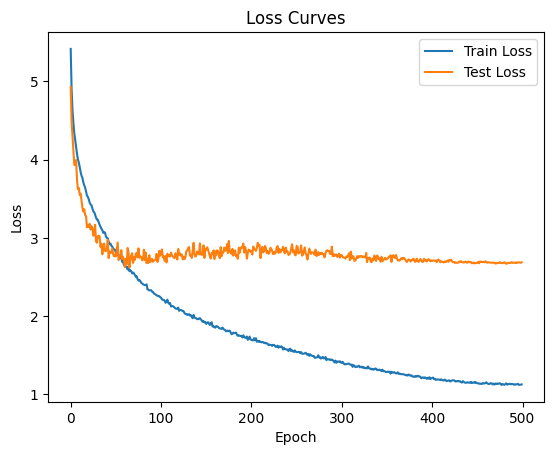

In [10]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

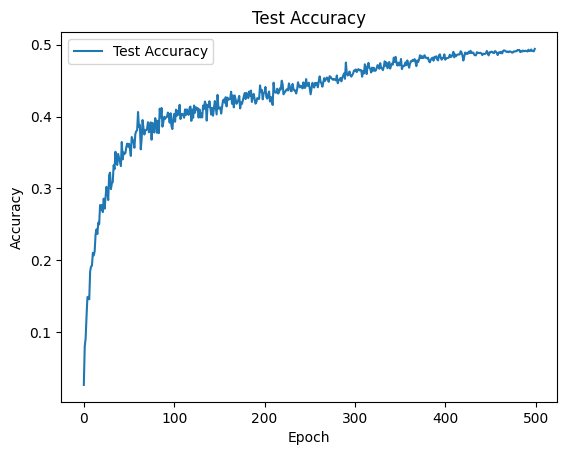

In [13]:
plt.plot(history['test_accuracy'], label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()